In [2]:
from netCDF4 import Dataset
import collections
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
from pathlib import Path
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd
import glob
import geopandas as gpd
import shapefile as shp 

In [3]:
#fh = Dataset("adaptor.mars.internal-1655727168.606427-18601-13-6d9e5cb6-ff7f-4034-b7f3-b6019b39c9e6.nc",mode='r')
ds = xr.open_dataset("spatially_refined_ladakh.nc",decode_cf=True)
fh = ds
#fh = ds.where((ds.longitude <= 79.5) & (ds.latitude <= 34.5) , drop = True)
# print(fh)
#fh['tcwv'] = fh['tcwv'] *fh['tcwv'].scale_factor + fh['tcwv'].add_offset

#print(fh['tcwv'])


In [4]:
lons = np.array(fh.variables['longitude'][:])
lats = np.array(fh.variables['latitude'][:])
pwv = np.array(fh.variables['tcwv'][:])
time = np.array(fh.variables['time'][:])

print(lats)

[35.25 35.   34.75 34.5  34.25 34.   33.75 33.5  33.25 33.   32.75 32.5
 32.25 32.  ]


In [45]:
print(lons)

[76.   76.25 76.5  76.75 77.   77.25 77.5  77.75 78.   78.25 78.5  78.75
 79.   79.25 79.5 ]


In [5]:
i=0
yearly_data = []
while(i<504):
    pwv_slice = fh['tcwv'][i:i+12]
    yearly_data.append(np.array(pwv_slice))

    i+=12
yearly_data = np.array(yearly_data)



To Save upto N minimum PWV locations for every year; Each minimum value is stored in a different file.

In [6]:
min_upto_val = 10
yearly_data_copy = yearly_data.copy()

for i in range(min_upto_val):
    min_arr =[]
    for year in range(42):
        np.set_printoptions(suppress=True)
        data = yearly_data_copy[year]
        min_val = np.nanmin(data)
        coord = np.unravel_index(np.nanargmin(data),data.shape)
        yearly_data_copy[year][coord[0]][coord[1]][coord[2]] = np.nan
        min_arr.append([year+1980,min_val,coord[0]+1,lats[coord[1]],lons[coord[2]]])
        

    np.savetxt('min_arr_'+str(i+1)+'.txt',min_arr,fmt='%d %f %d %f %f')

    

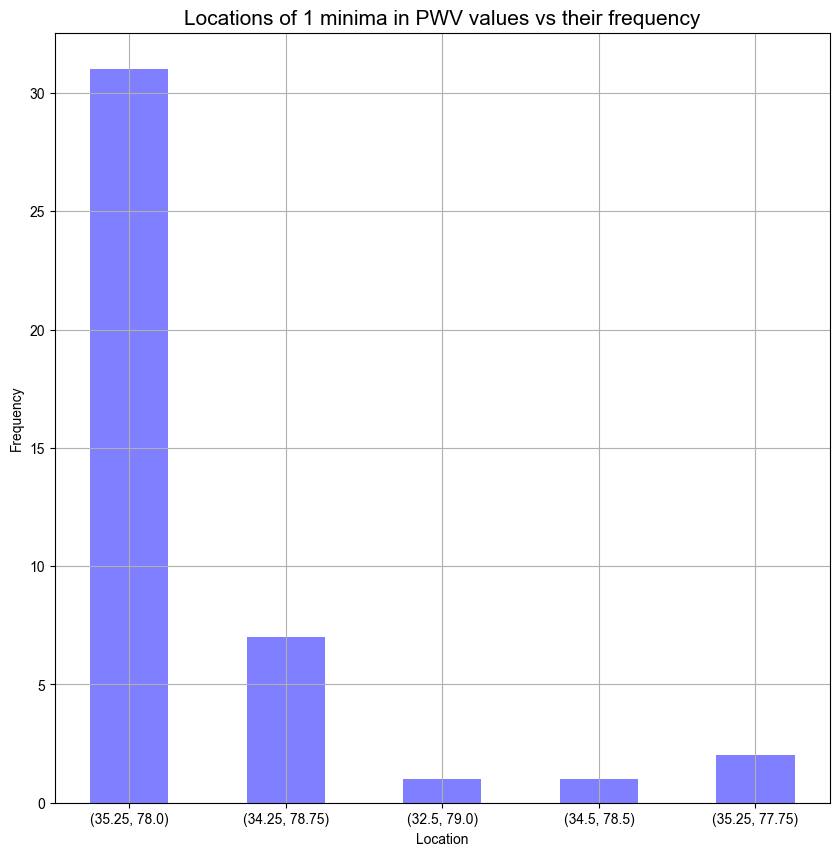

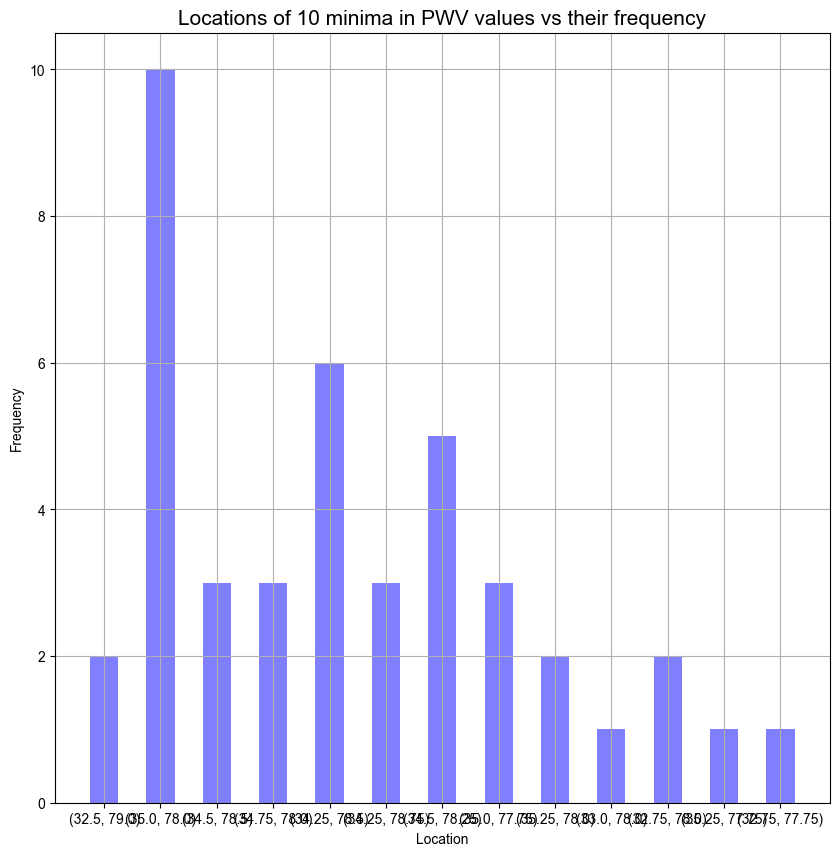

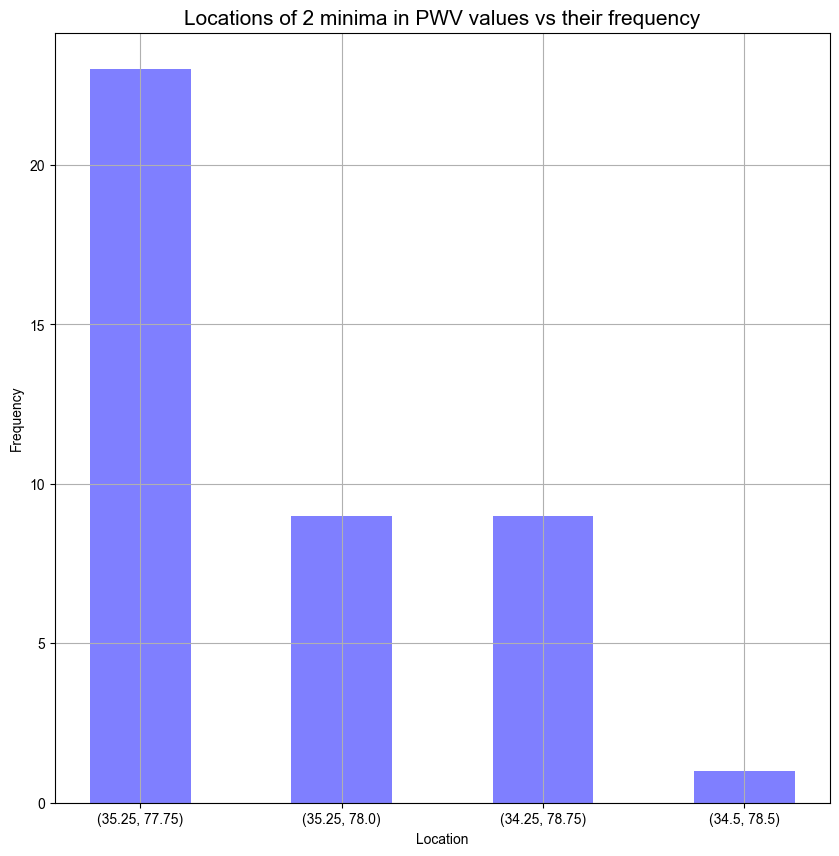

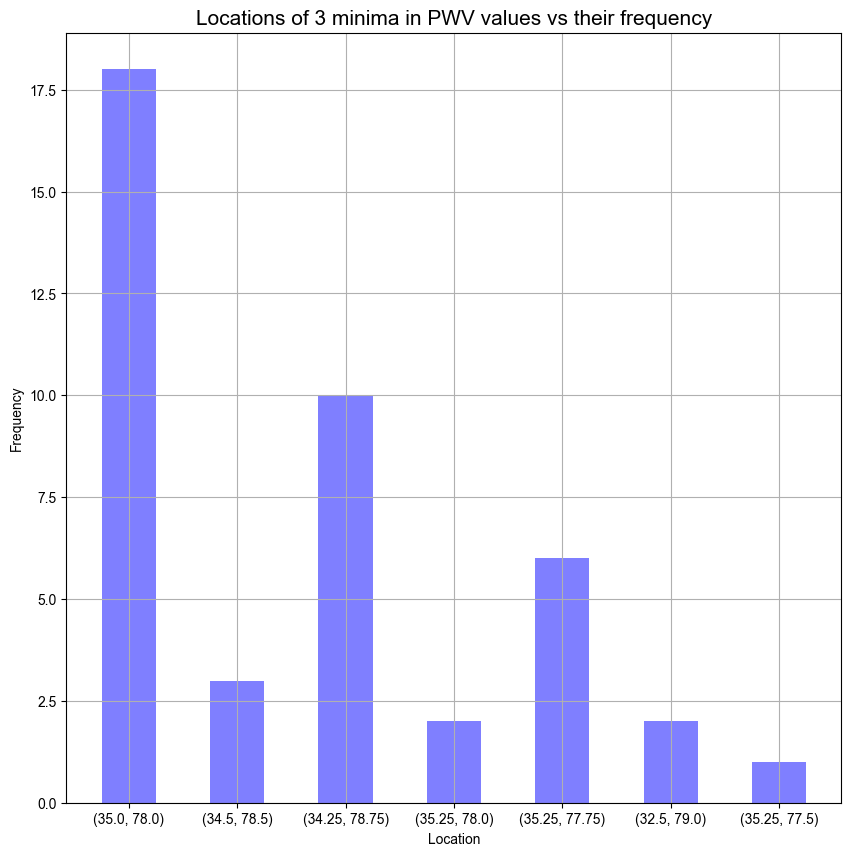

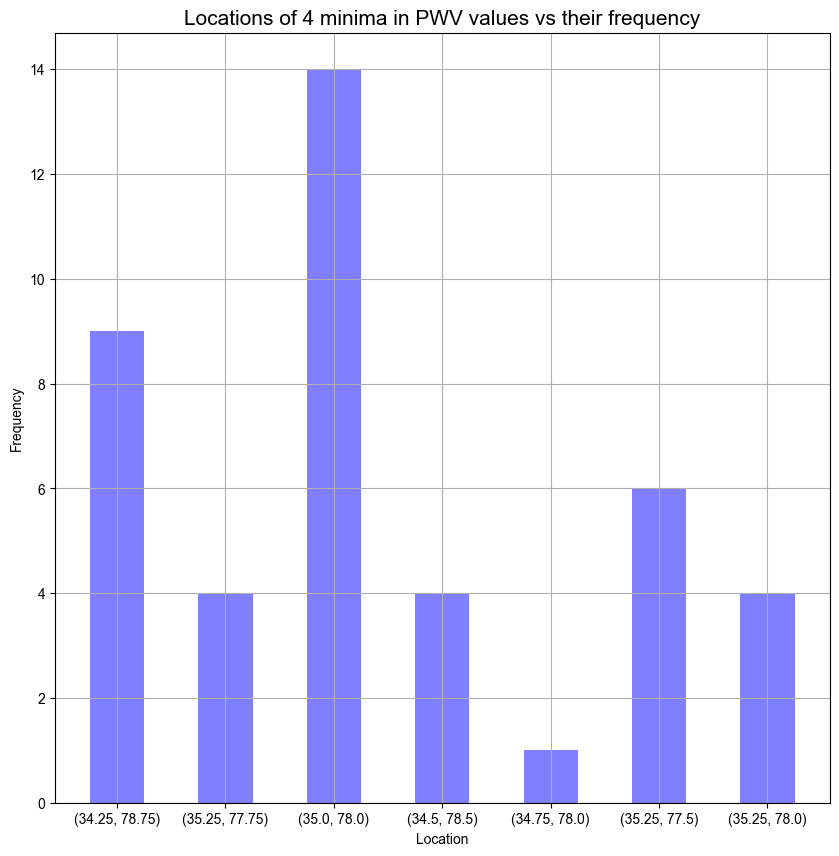

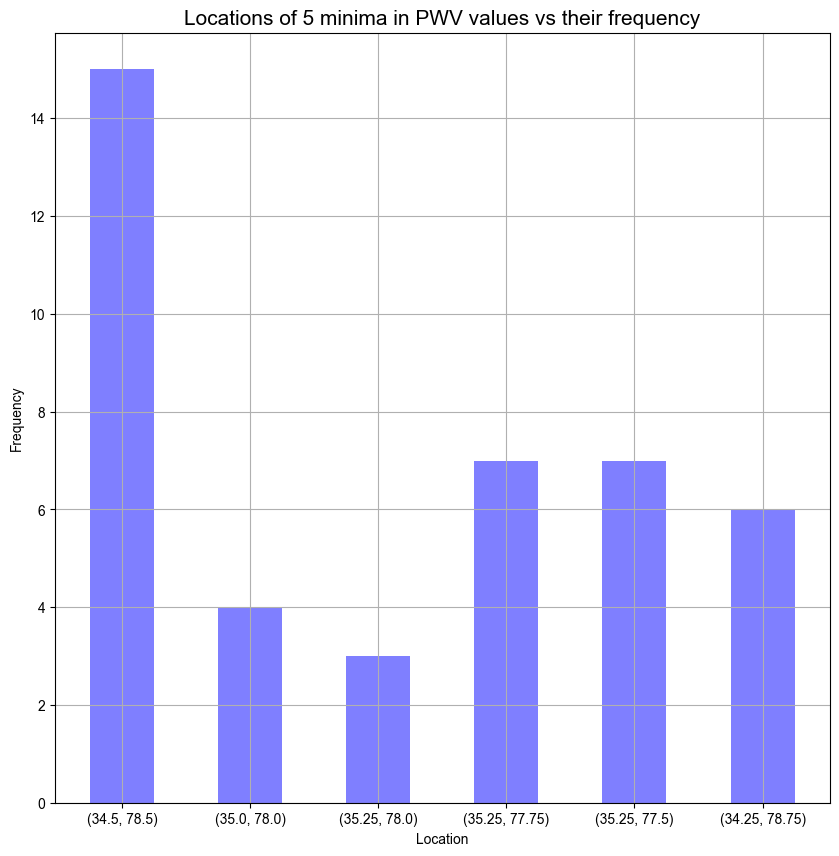

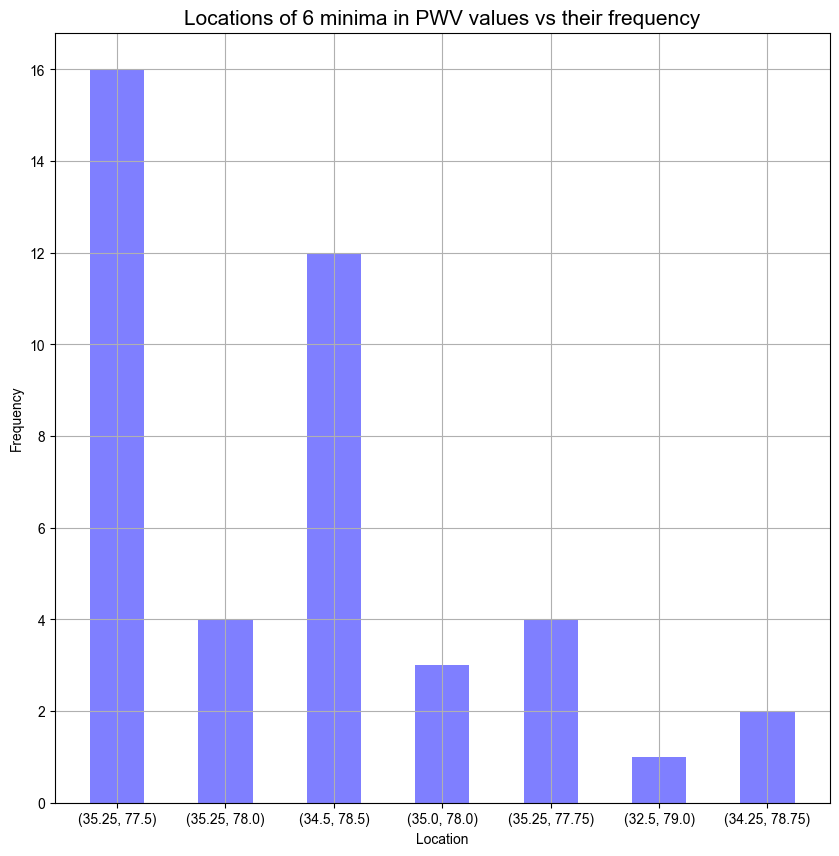

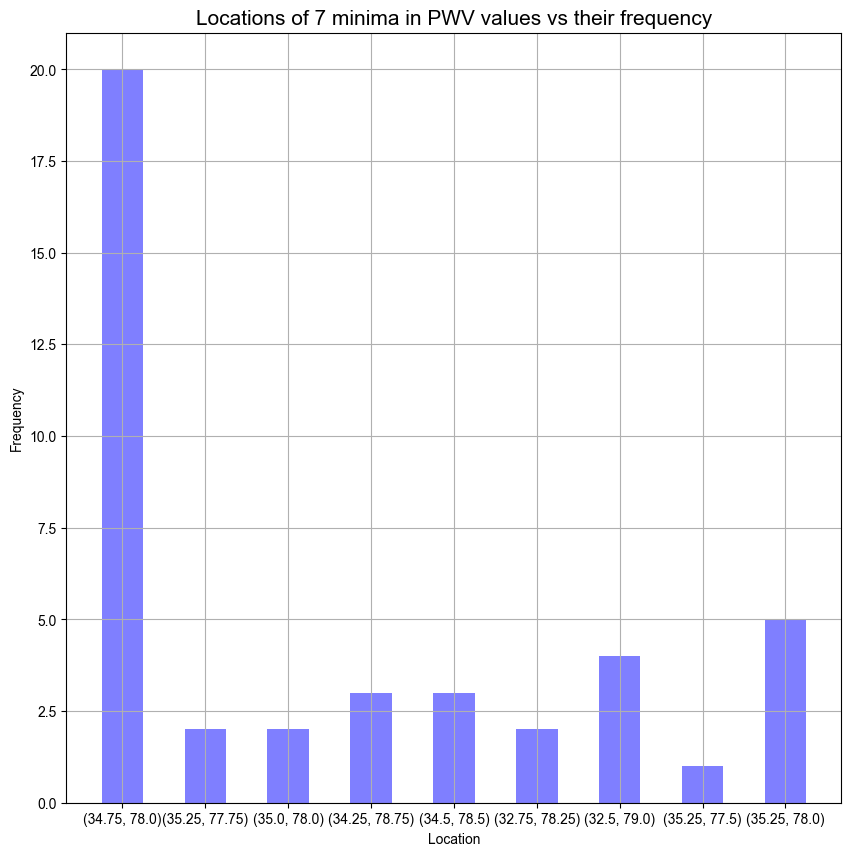

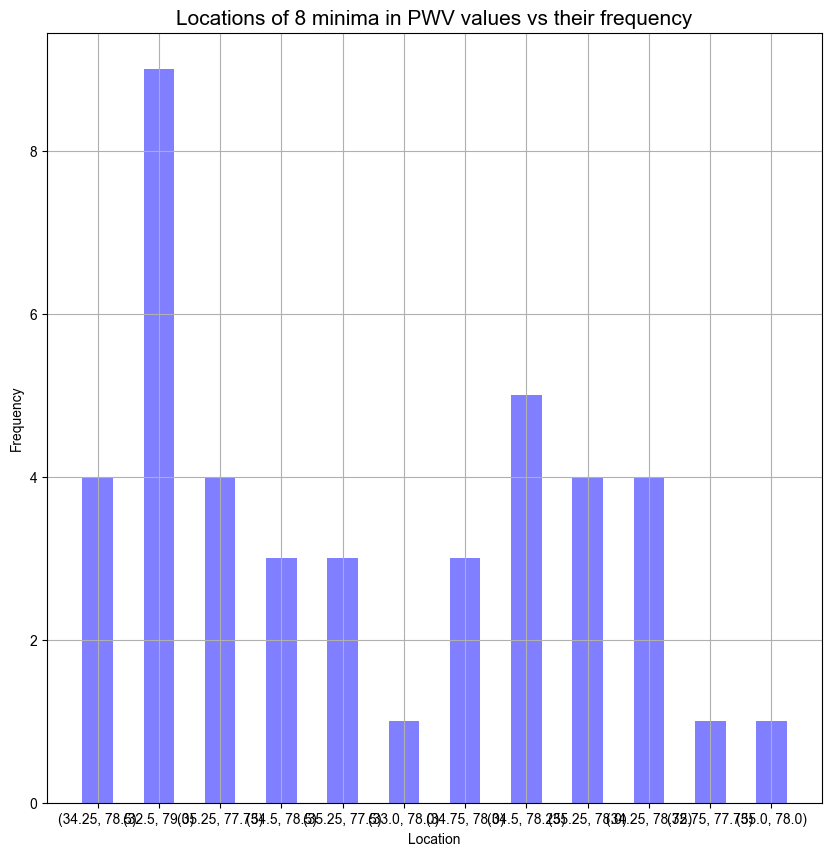

In [30]:
files=glob.glob("*.txt")
files = files[1:-1]

data_to_plot = []

for file in files:
    # if(d!=0):
    #     break

    # d+=1
    file_name = Path(file).stem
    file_number = file_name.split('_')[2]

    min_data = np.loadtxt(file)
    min_loc_data = min_data[:,3:5]
    counter = collections.Counter(map(tuple, min_loc_data))
    df = pd.Series(counter)
    plt.figure(figsize = (10,10))
    plt.bar(range(len(df)), df.values, align='center', width=0.5, color='blue', alpha=0.5, label='min_val',)
    plt.xticks(range(len(df)), df.index.values, size='medium')
    plt.xlabel('Location', fontsize=10)
    plt.ylabel('Frequency',fontsize = 10)
    plt.grid(True)
    plt.title('Locations of '+str(file_number)+' minima in PWV values vs their frequency',fontsize =15)
    #plt.savefig(file.replace('.txt','.png'))
    #plt.show()



In [7]:

def plot_locations(file,c):
    fontdict={'fontsize': '15', 'fontweight' : '3', 'family' : 'serif', 'color' : '#000000', 'horizontalalignment' : 'center'}
    min_data = np.loadtxt(file)
    min_loc_data = min_data[:,3:5]
    counter = collections.Counter(map(tuple, min_loc_data))
    # loc_data = np.array(counter.most_common(10))
    # loc_coords = loc_data[:,0]
    # lat = np.array([x[0] for x in loc_coords])
    # lon = np.array([x[1] for x in loc_coords])
    # loc_freq = loc_data[:,1]
    # loc_freq = [float(i)*20 for i in loc_freq ] 

    plt.figure(figsize = (10,10))

    m = Basemap(
                llcrnrlat = 32,
                urcrnrlat = 36,
                llcrnrlon = 76,
                urcrnrlon = 80,
                resolution = 'c')
    m.drawcoastlines()

    m.drawparallels(np.arange(32,36,1),labels=[True,False,False,False])
    m.drawmeridians(np.arange(76,80,1),labels=[0,0,0,1])
    m.drawrivers(linewidth=0.5, color='blue')
    m.drawstates(linewidth=0.5, color='blue')
   
    
    # Extract the coordinates and frequencies separately
    loc_counts = counter.most_common(10)
    loc_coords, loc_freq = zip(*loc_counts)

    # Convert the coordinates to separate latitude and longitude arrays
    lat = np.array([coord[0] for coord in loc_coords])
    lon = np.array([coord[1] for coord in loc_coords])

    # Convert loc_freq to float and scale
    loc_freq = np.array(loc_freq, dtype=float) * 20

    # Now create loc_data as a structured array
    loc_data = np.array(list(zip(lat, lon, loc_freq)), dtype=[('Lat', float), ('Lon', float), ('Freq', float)])

    plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


    #c=loc_freq

    sf = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\IND_adm\IND_adm2.shp")
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]

        plt.plot(x,y,color='black',linewidth=1)
        plt.xlim(xmin = 76, xmax = 80)
        plt.ylim(ymin = 32, ymax = 36)
    plt.grid()
    plt.ylabel('Latitude (°N) ',fontdict = fontdict,labelpad=30)
    plt.xlabel('Longitude (°E)',fontdict = fontdict,labelpad=30)
    m.drawcoastlines()        
    m.drawstates()
    m.drawcountries()
    m.drawmapboundary(fill_color="#DDEEFF")
    plt.plot(79.0002,32.7908,  'o', color='red', markersize=10)
    plt.text(79.0002,32.7908,  'HANLE', fontsize=15)
    plt.title('Locations with minimum PWV: ' + str(c) +' minima', fontsize=20)
    plt.savefig(file.replace('.txt','.jpeg'))
    


['min_arr_1.txt', 'min_arr_10.txt', 'min_arr_2.txt', 'min_arr_3.txt', 'min_arr_4.txt', 'min_arr_5.txt', 'min_arr_6.txt', 'min_arr_7.txt', 'min_arr_8.txt']
1


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


10


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


2


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


3


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


4


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


5


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


6


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


7


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


8


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


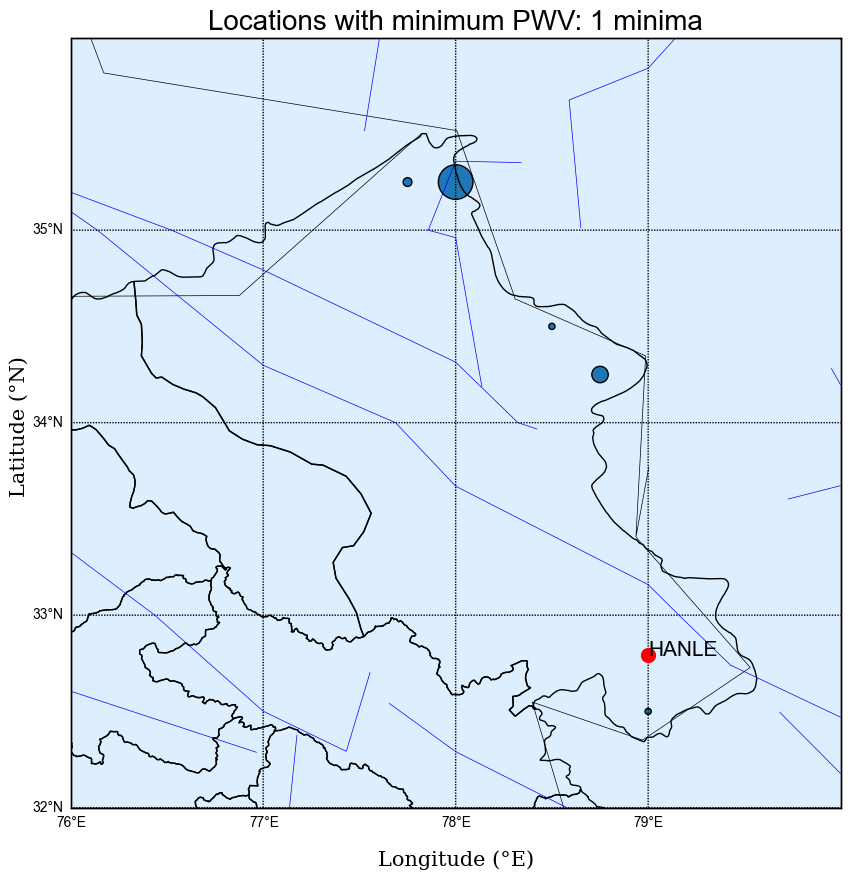

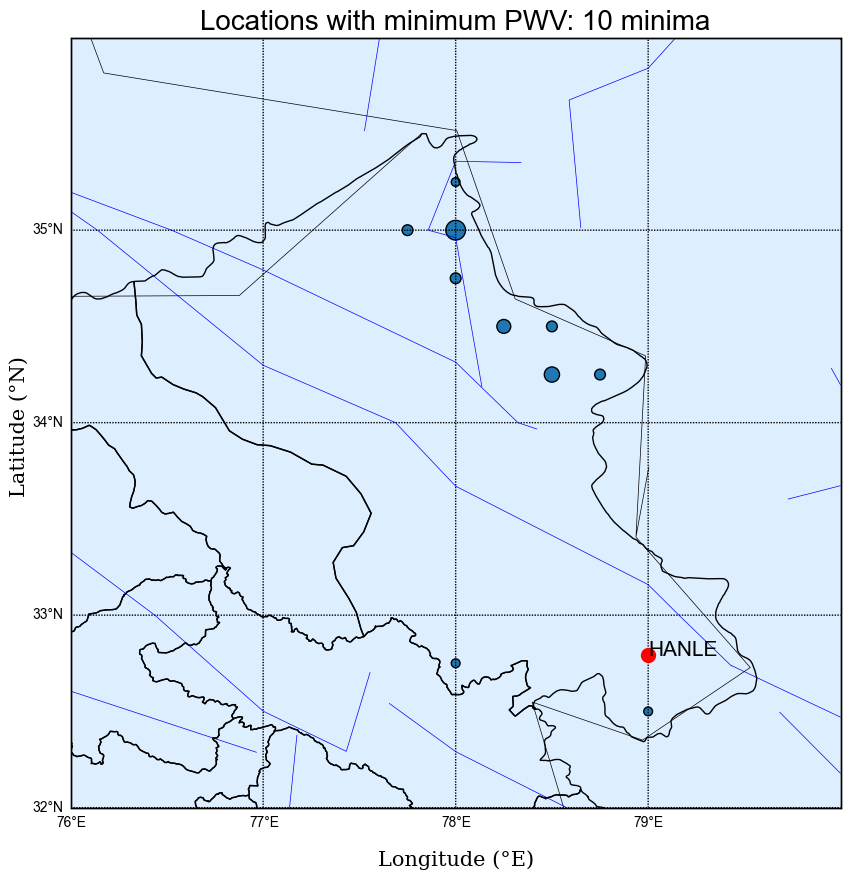

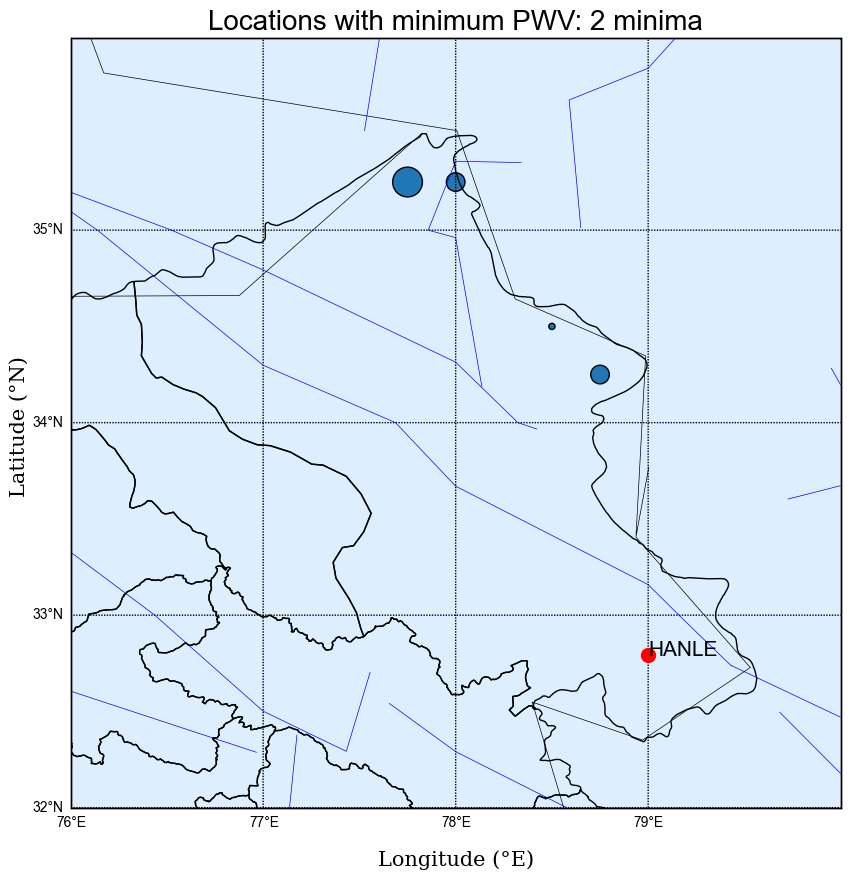

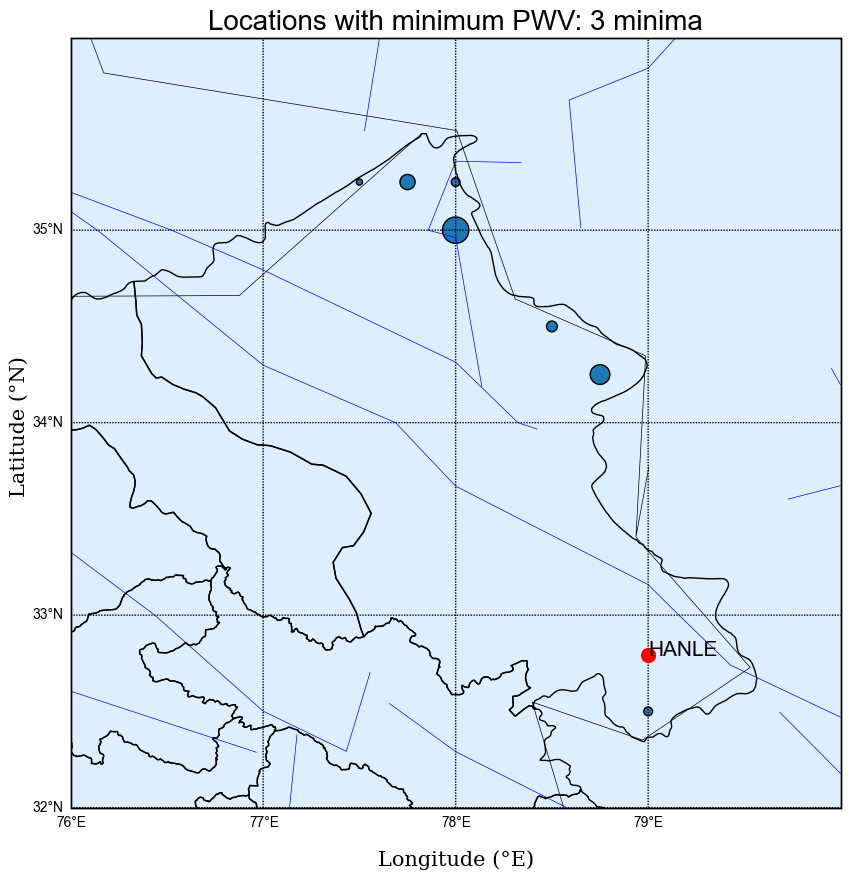

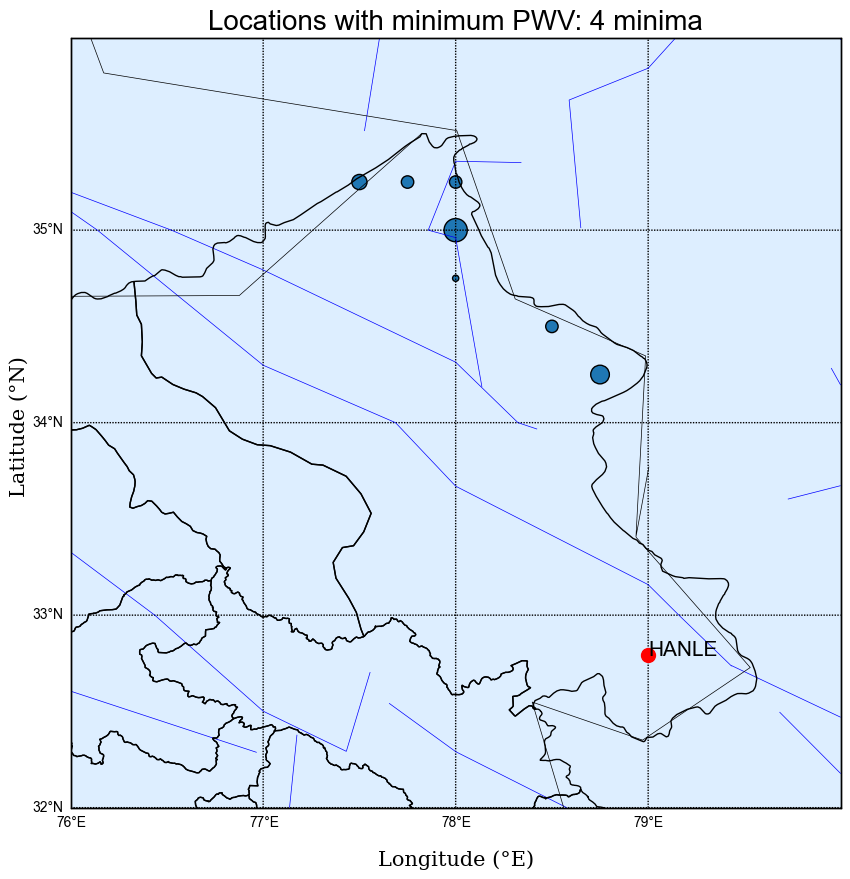

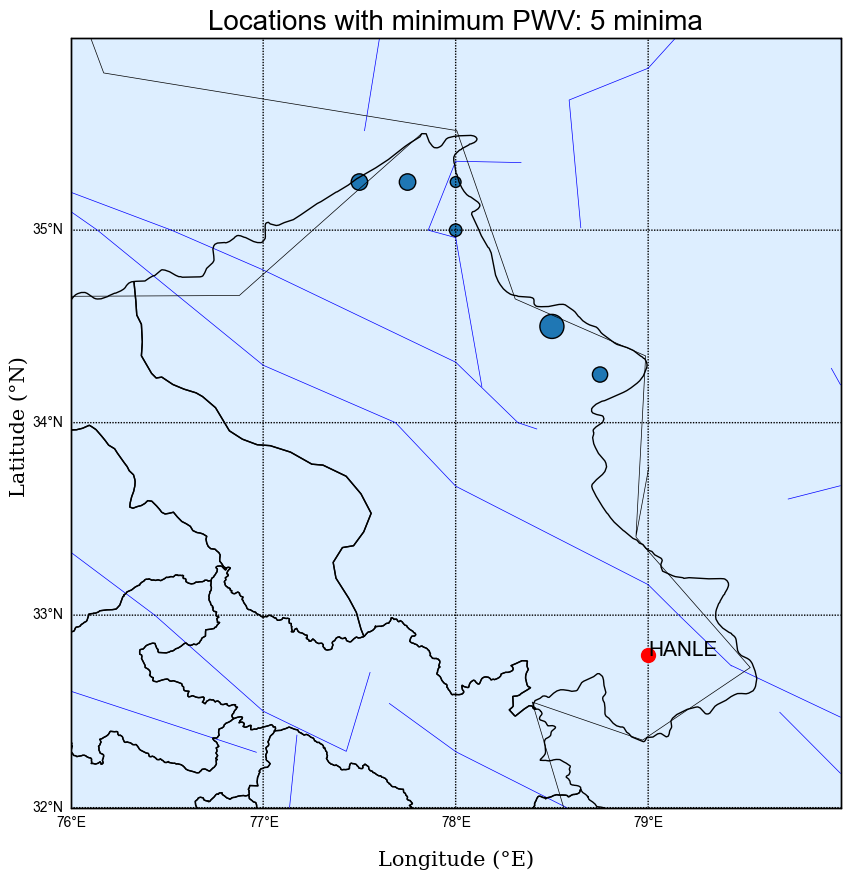

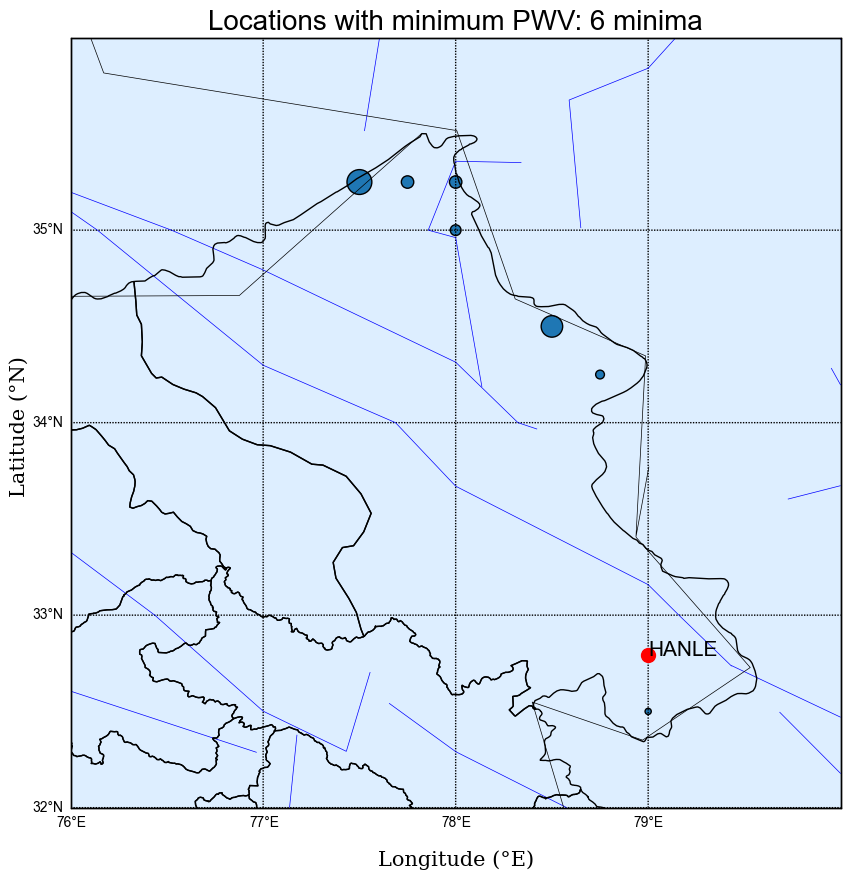

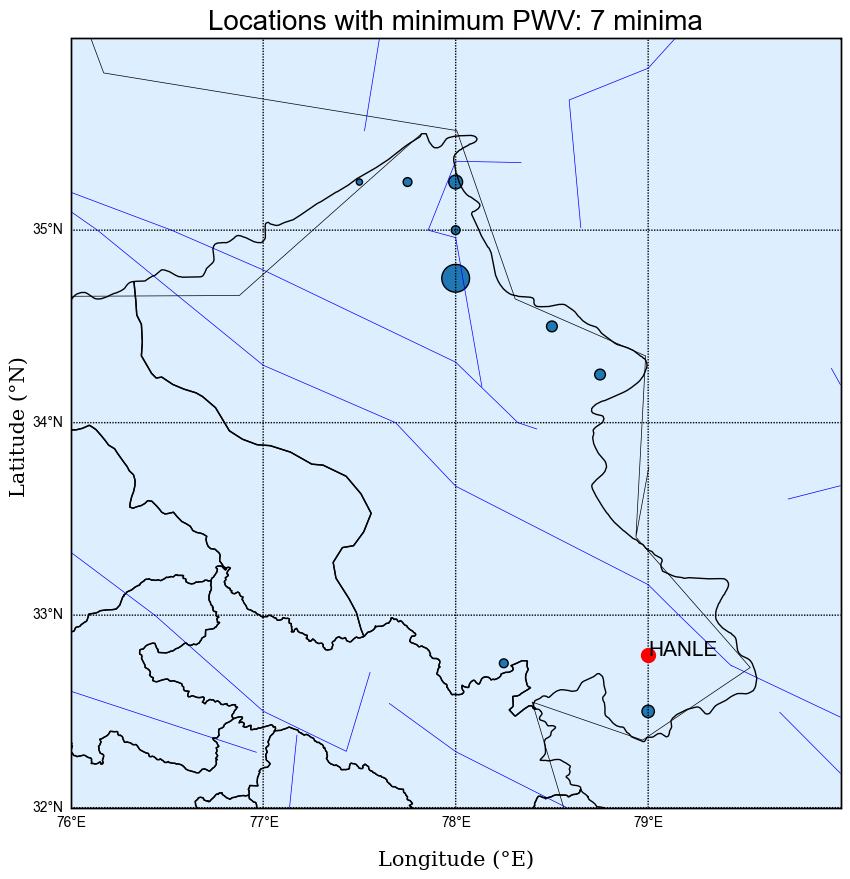

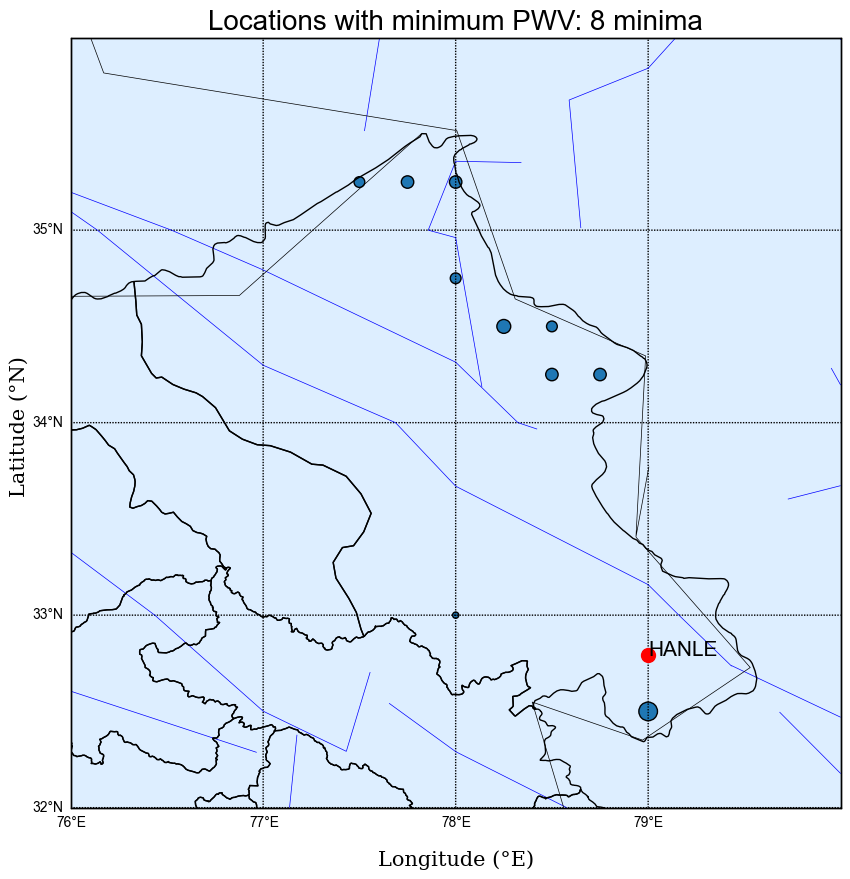

In [36]:

files = glob.glob("*.txt")
files = files[1:-1]
print(files)
for file in files:
    file_name = Path(file).stem
    file_number = file_name.split('_')[2]
    print(file_number)
    plot_locations(file,c = file_number)


In [8]:
i=0
yearly_data = []
while(i<504):
    pwv_slice = fh['tcwv'][i:i+12]
    yearly_data.append(np.array(pwv_slice))

    i+=12
yearly_data = np.array(yearly_data)
print(yearly_data.shape)

(42, 12, 14, 15)


In [9]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [10]:
def fetch_pwv_details(lat,lon,start_year = 1980,end_year = 2021):
    
    lat_idx = find_nearest(lats,lat)
    lon_idx = find_nearest(lons,lon)
    
    pwv_data_pixel = yearly_data[start_year-1980:end_year-1980+1,:,lat_idx,lon_idx]
    pwv_data_pixel = np.array(pwv_data_pixel)
    
    return np.array(np.array(pwv_data_pixel))

    

In [25]:
# Function to calculate required PWV statistics for a site
def calculate_pwv_statistics(lat, lon, start_year, end_year):
    pwv_data = fetch_pwv_details(lat, lon, start_year, end_year)
    pwv_data = np.reshape(pwv_data, (end_year - start_year + 1, 12))

    # 1. Median of 2021
    median_2021 = np.median(pwv_data[-1, :])

    # 2. Minimum from 1980 to 2021 and the corresponding year and month
    min_pwv_overall = np.min(pwv_data)
    overall_min_index = np.argmin(pwv_data)
    year_of_min_pwv = start_year + overall_min_index // 12
    month_of_min_pwv = overall_min_index % 12 + 1  # Adding 1 because months are 1-indexed

    # 3. Minimum of 2021
    min_pwv_2021 = np.min(pwv_data[-1, :])

    return median_2021, min_pwv_overall, year_of_min_pwv, month_of_min_pwv, min_pwv_2021

# Site coordinates
sites = {
    "Site A": (34.25, 78.75),
    "Site B": (33.00, 78.00),
    "Hanle": (32.79, 79.02),
    "Merak": (33.8, 78.62)
}

# Calculating and printing the statistics for each site
start_year = 1980
end_year = 2021

for site_name, (lat, lon) in sites.items():
    median_2021, min_pwv_overall, year_of_min_pwv, month_of_min_pwv, min_pwv_2021 = calculate_pwv_statistics(lat, lon, start_year, end_year)
    print(f"{site_name} (Lat: {lat}, Lon: {lon})")
    print(f"  Median PWV in 2021: {median_2021}")
    print(f"  Minimum PWV from 1980 to 2021: {min_pwv_overall}, Year: {year_of_min_pwv}, Month: {month_of_min_pwv}")
    print(f"  Minimum PWV in 2021: {min_pwv_2021}\n")

Site A (Lat: 34.25, Lon: 78.75)
  Median PWV in 2021: 1.4782514572143555
  Minimum PWV from 1980 to 2021: 0.5569171905517578, Year: 1995, Month: 1
  Minimum PWV in 2021: 0.7272167205810547

Site B (Lat: 33.0, Lon: 78.0)
  Median PWV in 2021: 1.7337017059326172
  Minimum PWV from 1980 to 2021: 0.6569347381591797, Year: 1986, Month: 1
  Minimum PWV in 2021: 0.8407497406005859

Hanle (Lat: 32.79, Lon: 79.02)
  Median PWV in 2021: 2.017085075378418
  Minimum PWV from 1980 to 2021: 0.7398319244384766, Year: 1985, Month: 2
  Minimum PWV in 2021: 1.0434894561767578

Merak (Lat: 33.8, Lon: 78.62)
  Median PWV in 2021: 1.8057870864868164
  Minimum PWV from 1980 to 2021: 0.7010860443115234, Year: 1995, Month: 1
  Minimum PWV in 2021: 0.902923583984375



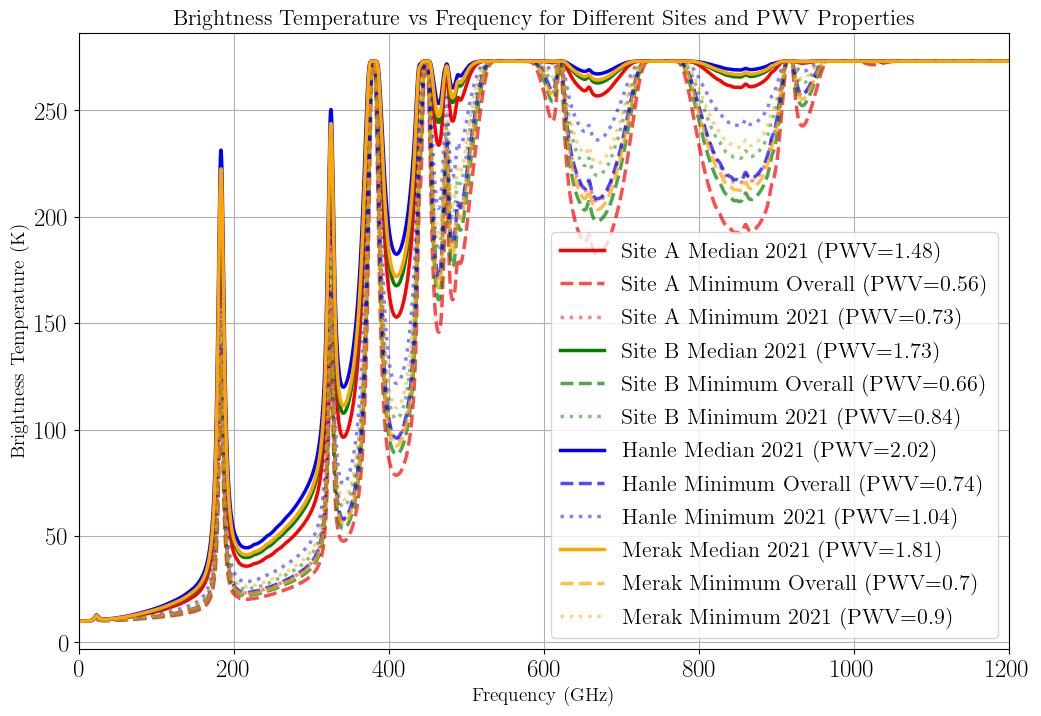

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os

def round_pwv(pwv):
    """
    Rounds the PWV value to two decimal places with specific rounding rules.
    """
    rounded_pwv = round(pwv, 2)
    if rounded_pwv % 1 == 0:  # If the number is like x.00
        return f"{int(rounded_pwv)}.0"  # Convert it to x.0
    return str(rounded_pwv)

def fetch_transmittance_data(pwv_value):
    """
    Fetches transmittance data for a given PWV value from the file.
    """
    file_path = f"D:/OneDrive - IIT Delhi/Intern/RRI/am-12.0-x64/Transmittance_Files/pwv_{pwv_value}.txt"
    if os.path.exists(file_path):
        data = np.loadtxt(file_path, usecols=[0, 2])  # Assuming frequency is in column 0 and temperature in column 2
        return data
    else:
        print(f"File not found: {file_path}")
        return None

def plot_brightness_temperature(site_pwv_values, site_names):
    """
    Plots the brightness temperature vs. frequency for each site and PWV value.
    """
    plt.figure(figsize=(12, 8))
    colors = ['red', 'green', 'blue', 'orange']  # Different colors for each site
    line_styles = ['-', '--', ':']  # Different line styles for each property type
    alphas = [1.0, 0.7, 0.5]  # Different opacities for each property type
    properties = ['Median 2021', 'Minimum Overall', 'Minimum 2021']  # Property types

    for i, site in enumerate(site_names):
        for j, pwv in enumerate(site_pwv_values[site]):
            rounded_pwv = round_pwv(pwv)
            data = fetch_transmittance_data(rounded_pwv)
            if data is not None:
                plt.plot(data[:, 0], data[:, 1], label=f'{site} {properties[j]} (PWV={rounded_pwv})',
                         color=colors[i], linestyle=line_styles[j], alpha=alphas[j])

    plt.xlabel('Frequency (GHz)', fontsize=14)
    plt.ylabel('Brightness Temperature (K)', fontsize=14)
    plt.xlim(0,1200)
    plt.title('Brightness Temperature vs Frequency for Different Sites and PWV Properties', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.savefig("brightness_temperature_comparison.png", dpi=300)
    plt.show()

# Actual PWV values for each site
site_pwv_values = {
    "Site A": [1.478, 0.557, 0.727],
    "Site B": [1.734, 0.657, 0.841],
    "Hanle": [2.017, 0.740, 1.043],
    "Merak": [1.806, 0.701, 0.903]
}
site_names = ["Site A", "Site B", "Hanle", "Merak"]

plot_brightness_temperature(site_pwv_values, site_names)


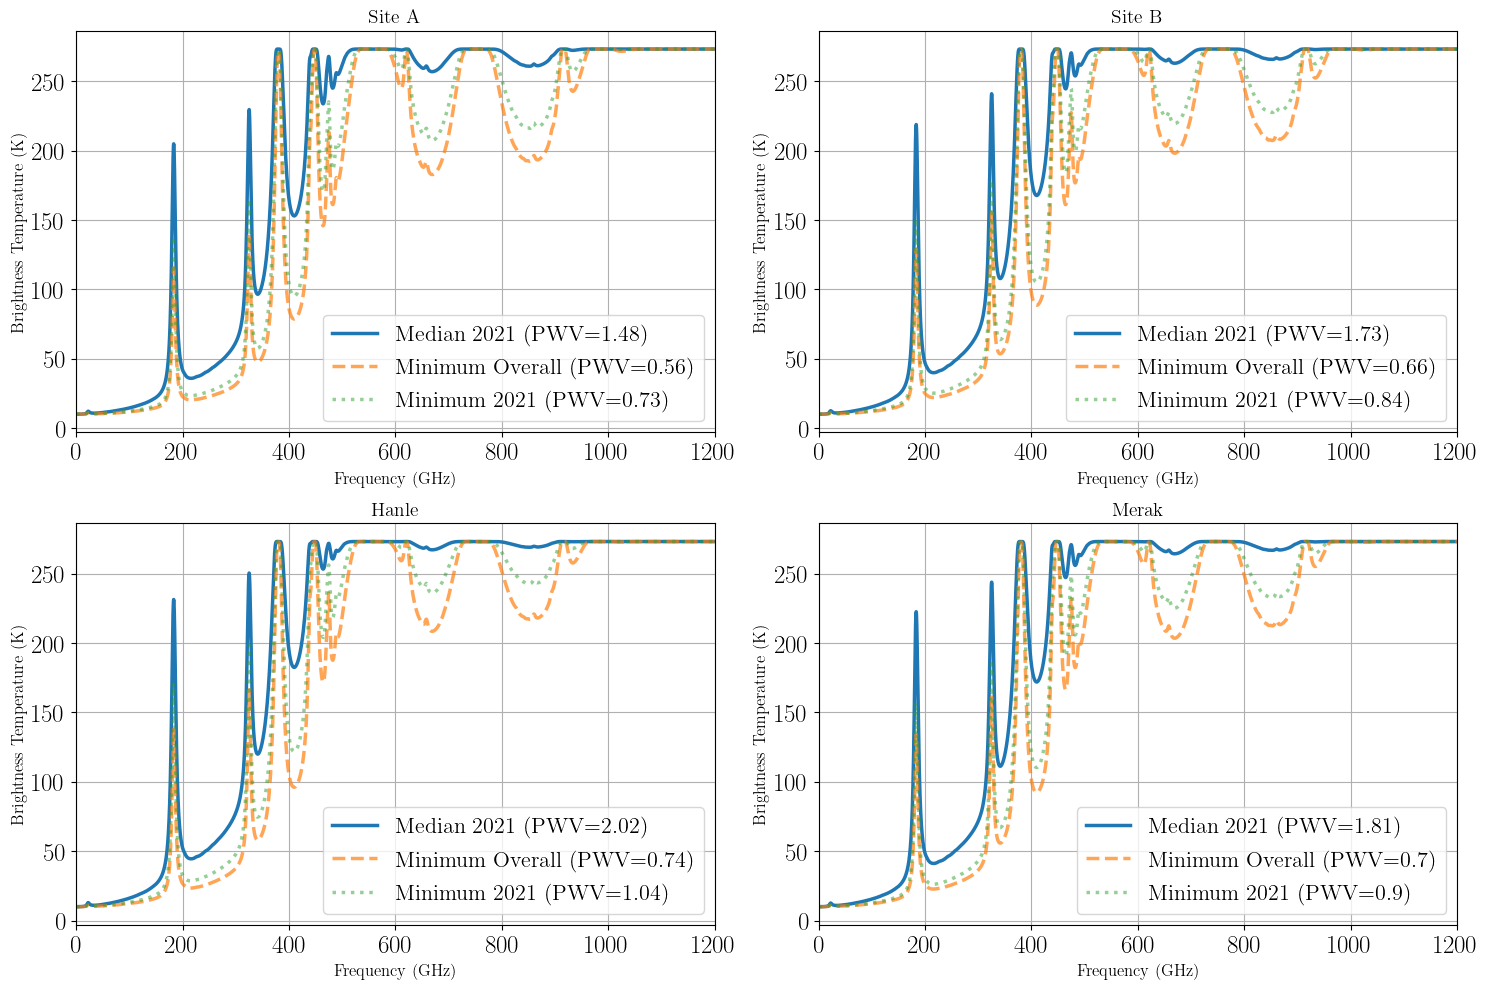

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import os

def round_pwv(pwv):
    """
    Rounds the PWV value to two decimal places with specific rounding rules.
    """
    rounded_pwv = round(pwv, 2)
    if rounded_pwv % 1 == 0:  # If the number is like x.00
        return f"{int(rounded_pwv)}.0"  # Convert it to x.0
    return str(rounded_pwv)

def fetch_transmittance_data(pwv_value):
    """
    Fetches transmittance data for a given PWV value from the file.
    """
    file_path = f"D:/OneDrive - IIT Delhi/Intern/RRI/am-12.0-x64/Transmittance_Files/pwv_{pwv_value}.txt"
    if os.path.exists(file_path):
        data = np.loadtxt(file_path, usecols=[0, 2])  # Assuming frequency is in column 0 and temperature in column 2
        return data
    else:
        print(f"File not found: {file_path}")
        return None

def plot_brightness_temperature_subplot(site_pwv_values):
    """
    Plots the brightness temperature vs. frequency for each site in a 2x2 subplot layout.
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.flatten()  # Flatten the 2x2 array for easy indexing
    line_styles = ['-', '--', ':']  # Different line styles for each property type
    alphas = [1.0, 0.7, 0.5]  # Different opacities for each property type
    properties = ['Median 2021', 'Minimum Overall', 'Minimum 2021']  # Property types

    for i, (site_name, pwv_values) in enumerate(site_pwv_values.items()):
        for j, pwv in enumerate(pwv_values):
            rounded_pwv = round_pwv(pwv)
            data = fetch_transmittance_data(rounded_pwv)
            if data is not None:
                axs[i].plot(data[:, 0], data[:, 1], label=f'{properties[j]} (PWV={rounded_pwv})',
                            linestyle=line_styles[j], alpha=alphas[j])

        axs[i].set_xlabel('Frequency (GHz)', fontsize=12)
        axs[i].set_ylabel('Brightness Temperature (K)', fontsize=12)
        axs[i].set_xlim(0,1200)
        axs[i].set_title(f'{site_name}', fontsize=14)
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.savefig("brightness_temperature_comparison_subplot_new.png", dpi=300)
    plt.show()

# Actual PWV values for each site
site_pwv_values = {
    "Site A": [1.478, 0.557, 0.727],
    "Site B": [1.734, 0.657, 0.841],
    "Hanle": [2.017, 0.740, 1.043],
    "Merak": [1.806, 0.701, 0.903]
}

plot_brightness_temperature_subplot(site_pwv_values)


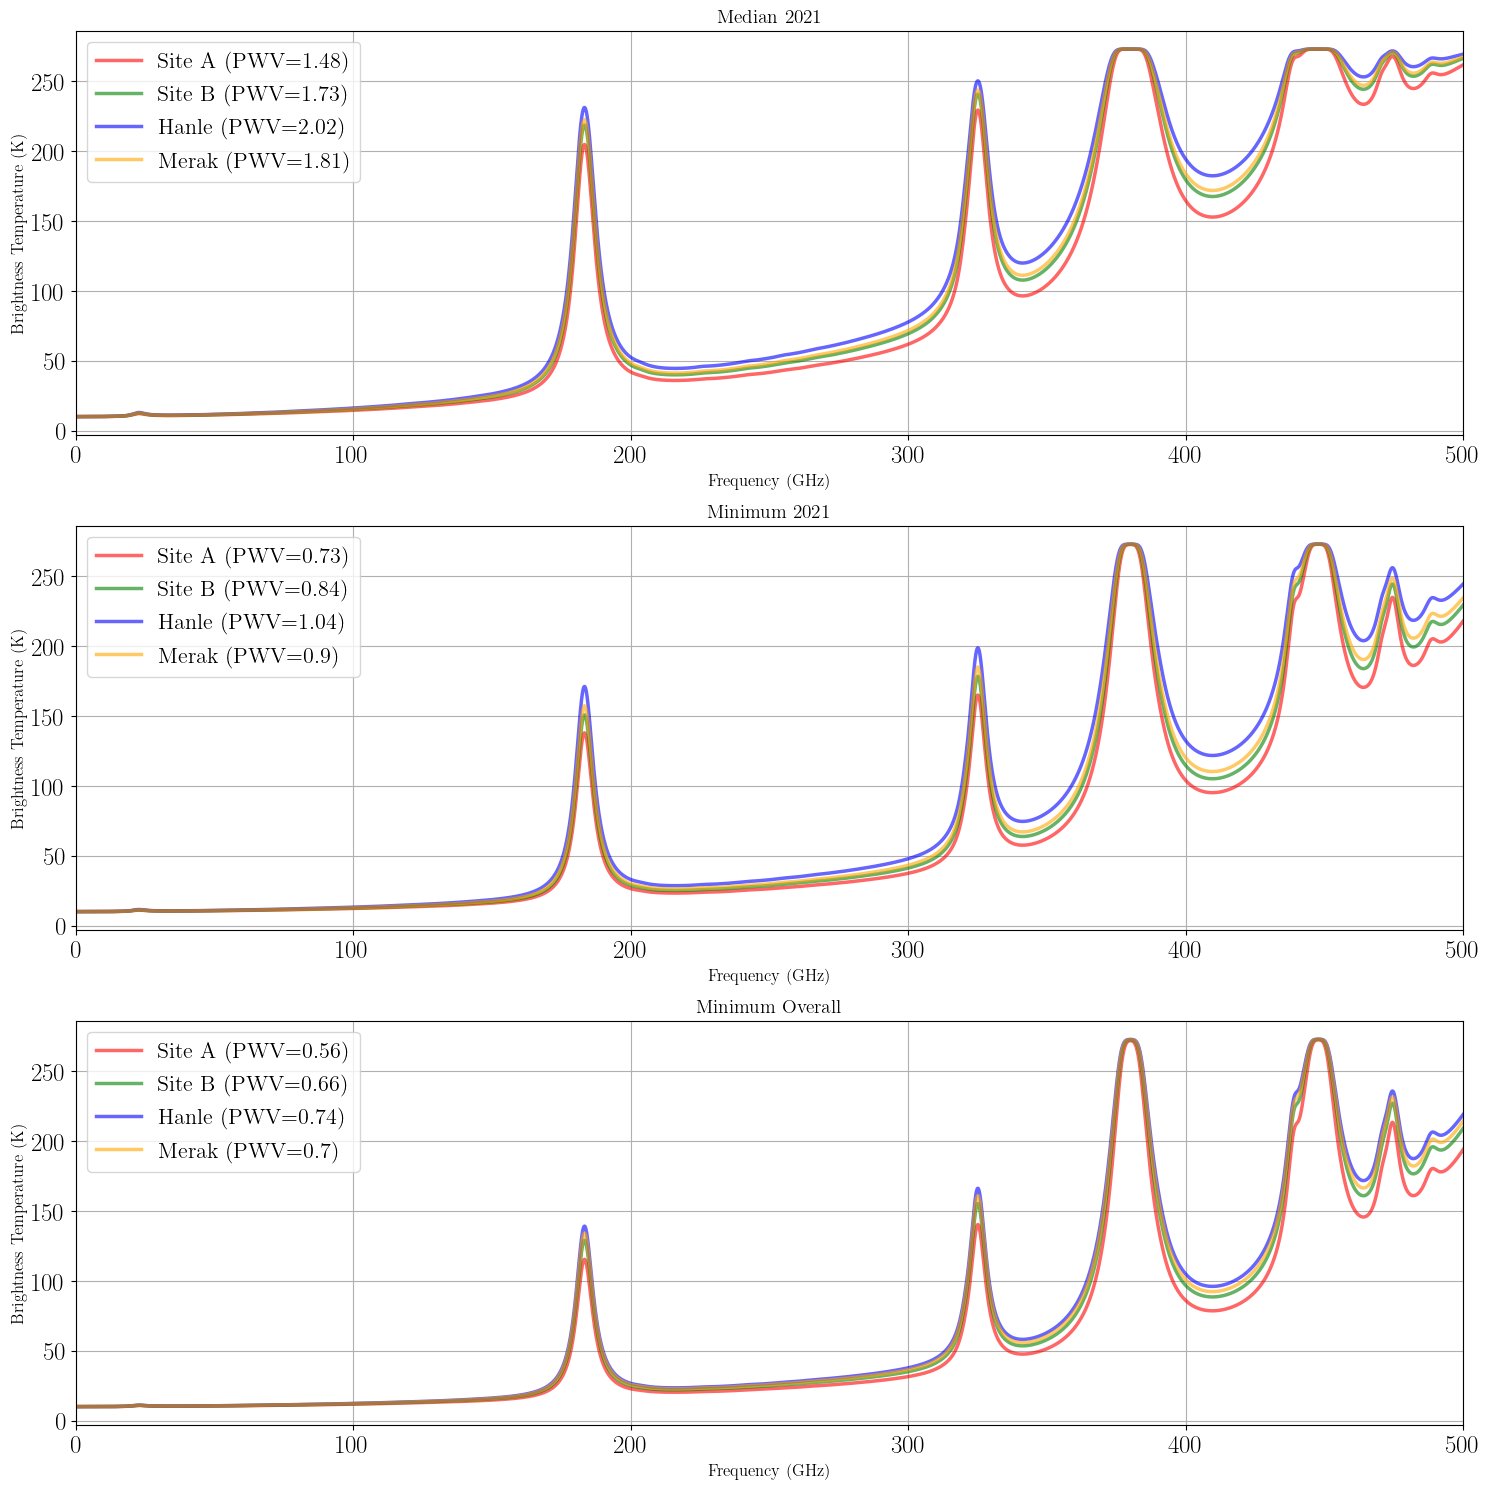

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec

def round_pwv(pwv):
    """
    Rounds the PWV value to two decimal places with specific rounding rules.
    """
    rounded_pwv = round(pwv, 2)
    if rounded_pwv % 1 == 0:  # If the number is like x.00
        return f"{int(rounded_pwv)}.0"  # Convert it to x.0
    return str(rounded_pwv)

def fetch_transmittance_data(pwv_value):
    """
    Fetches transmittance data for a given PWV value from the file.
    """
    file_path = f"D:/OneDrive - IIT Delhi/Intern/RRI/am-12.0-x64/Transmittance_Files/pwv_{pwv_value}.txt"
    if os.path.exists(file_path):
        data = np.loadtxt(file_path, usecols=[0, 2])  # Assuming frequency is in column 0 and temperature in column 2
        return data
    else:
        print(f"File not found: {file_path}")
        return None

def plot_brightness_temperature_subplot(site_pwv_values, properties, site_names):
    """
    Plots the brightness temperature vs. frequency for each property in separate subplots.
    """
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1,1])
    colors = ['red', 'green', 'blue', 'orange']  # Different colors for each site

    for i, property in enumerate(properties):
        if i != 1:  # For properties 1 and 3
            ax = plt.subplot(gs[i // 2, i % 2])
        else:  # For property 2
            ax = plt.subplot(gs[2, :])

        for j, site_name in enumerate(site_names):
            rounded_pwv = round_pwv(site_pwv_values[site_name][i])
            data = fetch_transmittance_data(rounded_pwv)
            if data is not None:
                ax.plot(data[:, 0], data[:, 1], label=f'{site_name} (PWV={rounded_pwv})',
                        color=colors[j], alpha=0.6)

        ax.set_xlabel('Frequency (GHz)', fontsize=12)
        ax.set_ylabel('Brightness Temperature (K)', fontsize=12)
        ax.set_xlim(0, 500)
        ax.set_title(f'{property}', fontsize=14)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig("brightness_temperature_comparison_subplot.png", dpi=300)
    plt.show()

# Actual PWV values for each site
site_pwv_values = {
    "Site A": [1.478, 0.557, 0.727],
    "Site B": [1.734, 0.657, 0.841],
    "Hanle": [2.017, 0.740, 1.043],
    "Merak": [1.806, 0.701, 0.903]
}
site_names = ["Site A", "Site B", "Hanle", "Merak"]
properties = ['Median 2021', 'Minimum Overall', 'Minimum 2021']

plot_brightness_temperature_subplot(site_pwv_values, properties, site_names)


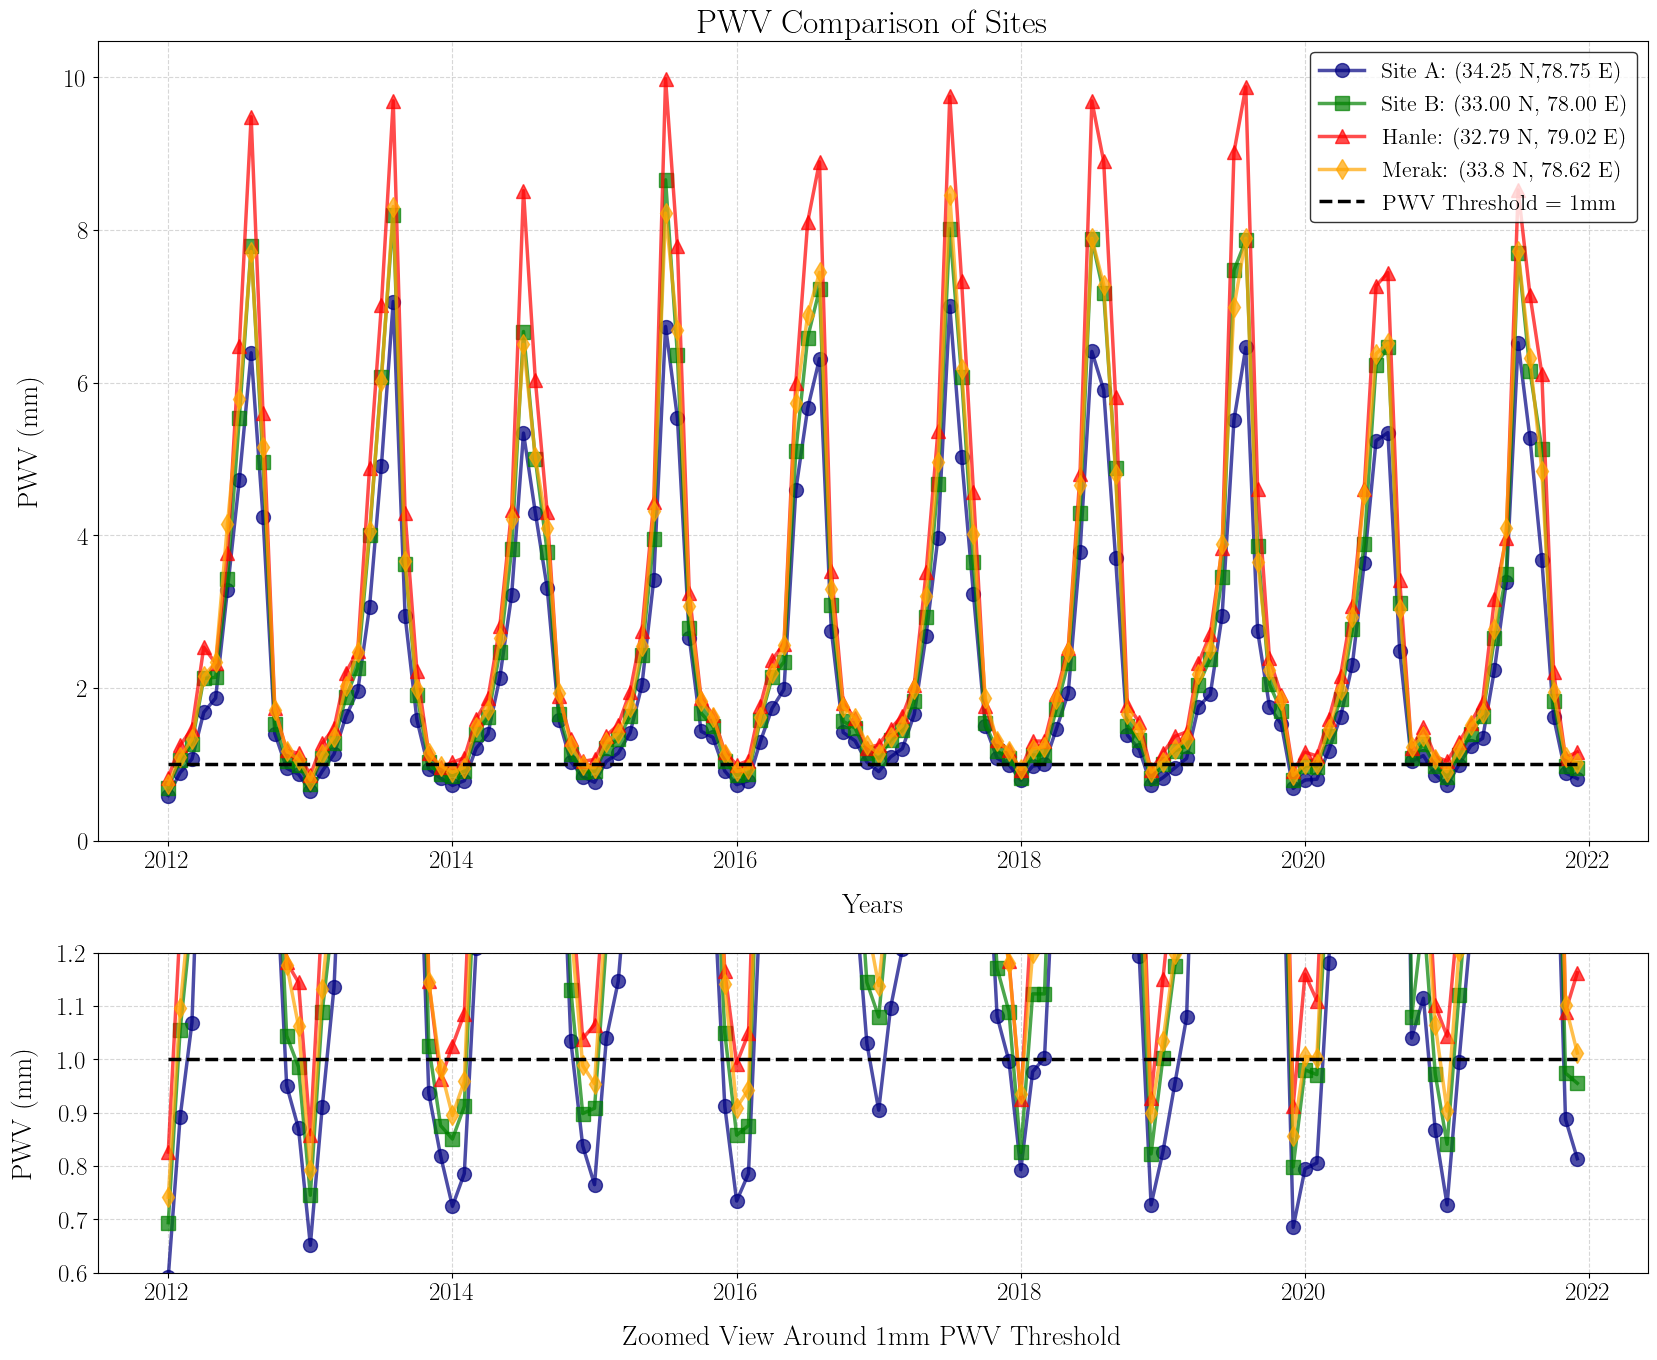

In [23]:
import matplotlib.gridspec as gridspec
def plot_pwv_for_loc(lat, lon, start_year=1980, end_year=2021):
    # Improved plot configurations for publication quality
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': 'Times New Roman',
        'axes.labelsize': 20,
        'axes.titlesize': 24,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16,
        'lines.markersize': 10,
        'lines.linewidth': 2.5
    })

    # Set up a grid for the subplots
    fig = plt.figure(figsize=(20, 16))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    # Fetching and reshaping PWV data
    pwv_data_pixel = np.reshape(fetch_pwv_details(lat, lon, start_year, end_year), 
                                (end_year - start_year + 1) * 12)
    pwv_data_pixel_hanle = np.reshape(fetch_pwv_details(32.77, 78.96, start_year, end_year), 
                                      (end_year - start_year + 1) * 12)
    pwv_data_pixel_other = np.reshape(fetch_pwv_details(33.00, 78.00, start_year, end_year), 
                                      (end_year - start_year + 1) * 12)
    pwv_data_pixel_merak = np.reshape(fetch_pwv_details( 33.79,78.61, start_year, end_year), 
                                      (end_year - start_year + 1) * 12)


    # Generating time array
    time = np.array([i + j / 12 for i in range(start_year, end_year + 1) for j in range(12)])

    # First Subplot: Full data
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_xlabel("Years", labelpad=15)
    ax1.set_ylabel("PWV (mm)", labelpad=15)
    ax1.set_title("PWV Comparison of Sites")

    # High contrast color palette and distinct markers
    colors = ['navy', 'green', 'red', 'orange']
    markers = ['o', 's', '^', 'd']  # Circle, Square, Triangle, Diamond
    labels = ['Site A: (34.25 N,78.75 E)', 'Site B: (33.00 N, 78.00 E)', 
              'Hanle: (32.79 N, 79.02 E)', 'Merak: (33.8 N, 78.62 E)']
    data_sets = [pwv_data_pixel, pwv_data_pixel_other, pwv_data_pixel_hanle, pwv_data_pixel_merak]

    for data, color, label, marker in zip(data_sets, colors, labels, markers):
        ax1.plot(time, data, color=color, label=label, marker=marker, alpha=0.7)

    ax1.plot(time, [1] * len(time), color='black', linestyle='--', label='PWV Threshold = 1mm')
    ax1.set_ylim(0, max(pwv_data_pixel_hanle) + 0.5)
    legend = ax1.legend(loc='upper right', frameon=True)
    legend.get_frame().set_edgecolor('black')

    # Second Subplot: Zoomed-in around 1mm line
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_ylabel("PWV (mm)", labelpad=15)
    ax2.set_xlabel("Zoomed View Around 1mm PWV Threshold", labelpad=15)

    zoom_range = [0.6, 1.2]
    ax2.set_ylim(zoom_range)
    for data, color, marker in zip(data_sets, colors, markers):
        ax2.plot(time, data, color=color, marker=marker, alpha=0.7)

    ax2.plot(time, [1] * len(time), color='black', linestyle='--')

    # Save or show the plot
    plt.savefig("pwv_comparison_with_zoom.png", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
plot_pwv_for_loc(34.25, 78.75, start_year=2012, end_year=2021)

#### Site A    34.25 N,78.75 E
#### Site B    33.00 N, 78.00 E
#### Hanle     32.79 N, 79.02 E
#### Merak     33.8 N, 78.62 E

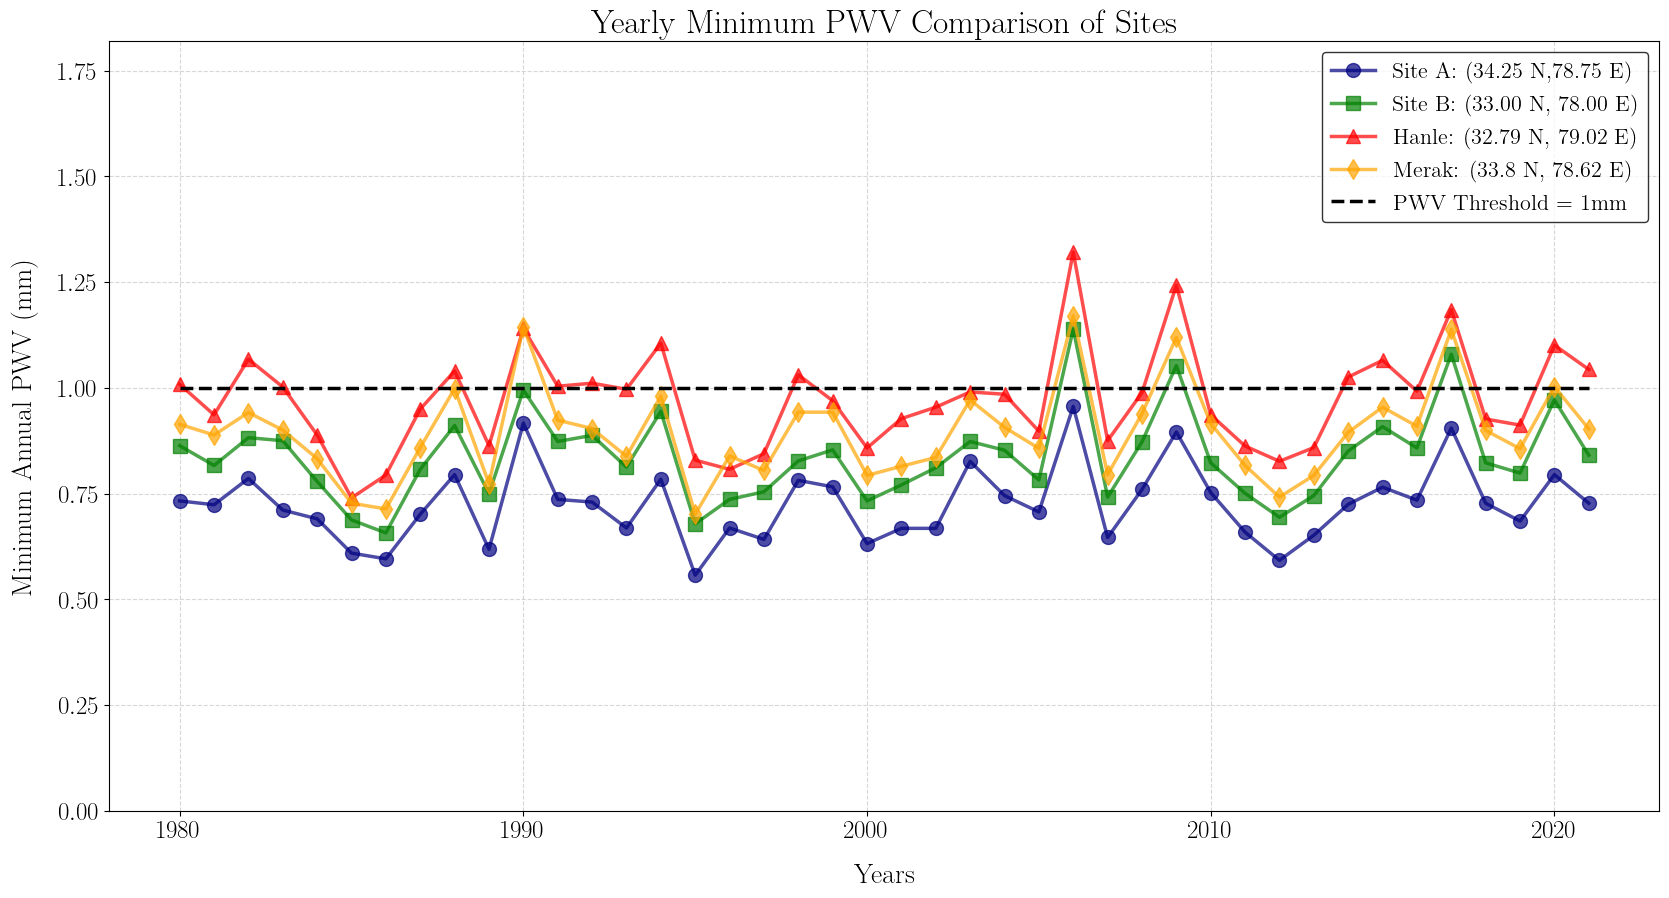

In [21]:
def plot_pwv_minima_for_loc(lat, lon, start_year=1980, end_year=2021):
    # Improved plot configurations for publication quality
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': 'Times New Roman',
        'axes.labelsize': 20,
        'axes.titlesize': 24,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16,
        'lines.markersize': 10,
        'lines.linewidth': 2.5
    })

    # Function to compute yearly minima
    def yearly_minima(data):
        reshaped_data = data.reshape(-1, 12)
        return reshaped_data.min(axis=1)

    # Fetching and reshaping PWV data
    pwv_data_pixel = yearly_minima(np.reshape(fetch_pwv_details(lat, lon, start_year, end_year), 
                                              (end_year - start_year + 1, 12)))
    pwv_data_pixel_hanle = yearly_minima(np.reshape(fetch_pwv_details(32.77, 78.96, start_year, end_year), 
                                                    (end_year - start_year + 1, 12)))
    pwv_data_pixel_other = yearly_minima(np.reshape(fetch_pwv_details(33, 78.0, start_year, end_year), 
                                                    (end_year - start_year + 1, 12)))
    pwv_data_pixel_merak = yearly_minima(np.reshape(fetch_pwv_details(33.79, 78.61, start_year, end_year), 
                                                    (end_year - start_year + 1, 12)))

    # Generating year array
    time_years = np.arange(start_year, end_year + 1)

    # Creating the plot
    plt.figure(figsize=(20, 10))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlabel("Years", labelpad=15)
    plt.ylabel("Minimum Annual PWV (mm)", labelpad=15)
    plt.title("Yearly Minimum PWV Comparison of Sites")

    # Defining markers and colors
    markers = ['o', 's', '^', 'd']  # Circle, Square, Triangle, Diamond
    colors = ['navy', 'green', 'red', 'orange']
    labels = ['Site A: (34.25 N,78.75 E)', 'Site B: (33.00 N, 78.00 E)', 
              'Hanle: (32.79 N, 79.02 E)', 'Merak: (33.8 N, 78.62 E)']
    data_sets = [pwv_data_pixel, pwv_data_pixel_other, pwv_data_pixel_hanle, pwv_data_pixel_merak]

    for data, color, label, marker in zip(data_sets, colors, labels, markers):
        plt.plot(time_years, data, color=color, label=label, marker=marker, alpha=0.7)

    plt.plot(time_years, [1] * len(time_years), color='black', linestyle='--', label='PWV Threshold = 1mm')
    plt.ylim(0, max(pwv_data_pixel_hanle) + 0.5)
    legend = plt.legend(loc='upper right', frameon=True)
    legend.get_frame().set_edgecolor('black')
    plt.xlim(start_year-0.5, end_year+1)
    # Save or show the plot
    plt.savefig("pwv_minima_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
plot_pwv_minima_for_loc(34.25, 78.75, start_year=1980, end_year=2021)

In [12]:
def calc_total_below_threshold(lat,lon,threshold,start_year=1980,end_year=2021):
    pwv_data_pixel = fetch_pwv_details(lat,lon,start_year,end_year)
    
    total_count = []
    for i in range(end_year-start_year+1):
        count = 0
        for j in range(12):
            if pwv_data_pixel[i][j] < threshold:
                count = count + 1
    
        total_count.append([start_year+i,count])
        
    return (np.array(total_count))
a = calc_total_below_threshold(34.25,  78.75 ,1,start_year=1980,end_year=2021)
print(np.sum(a[:,1]))
print(np.median(a[:,1]))
b = calc_total_below_threshold(32.7908, 79.0002,threshold=1,start_year=1980,end_year=2021)
print(np.sum(b[:,1]))
print(np.median(b[:,1]))
c = calc_total_below_threshold(33, 78,threshold=1,start_year=1980,end_year=2021)
print(np.sum(c[:,1]))
print(np.median(c[:,1]))

135
3.0
33
1.0
76
2.0


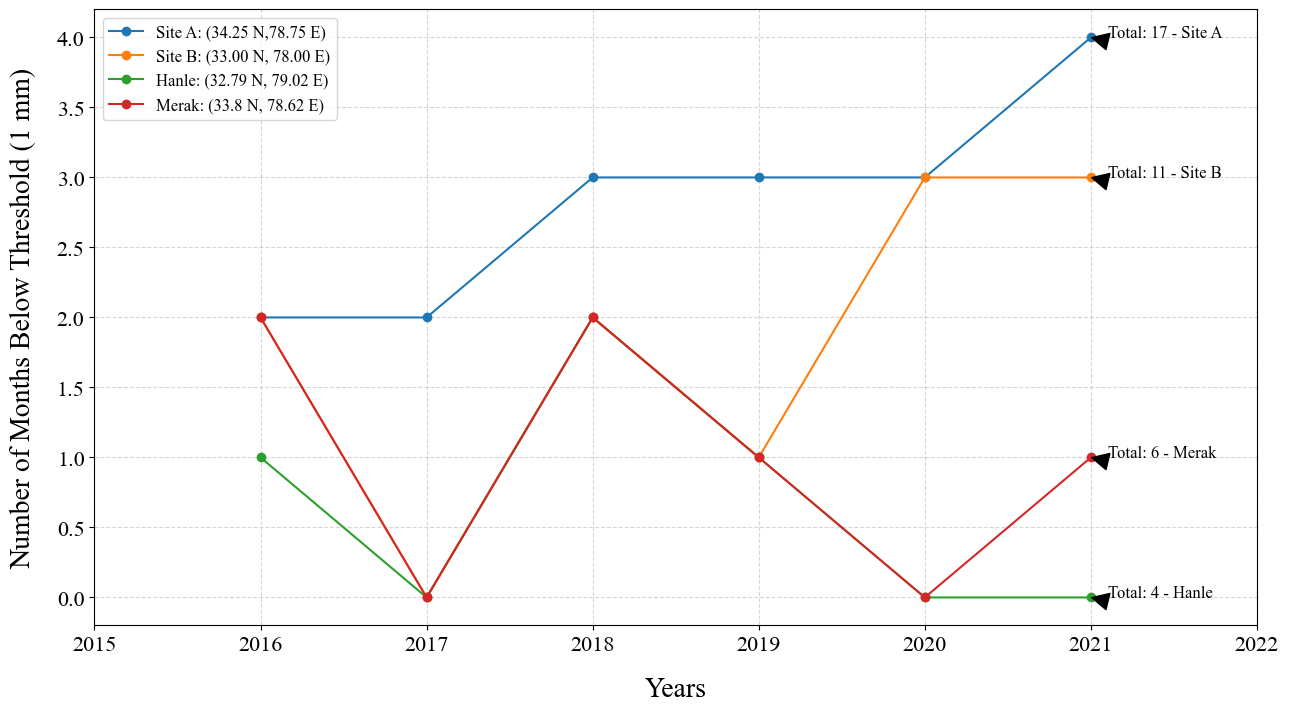

Total number of months below 1mm PWV threshold for Site A: 17
Total number of months below 1mm PWV threshold for Site B: 11
Total number of months below 1mm PWV threshold for Hanle: 4
Total number of months below 1mm PWV threshold for Merak: 6


In [25]:
# Calculate the total number of months below a threshold for a given location for a given time period i.e from 2016 to 2021 for all locations
site_a = calc_total_below_threshold(34.25,  78.75 ,1,start_year=2016,end_year=2021)
site_b = calc_total_below_threshold(33.00,  78.00 ,1,start_year=2016,end_year=2021)
hanle = calc_total_below_threshold(32.7908, 79.0002,1,start_year=2016,end_year=2021)
merak = calc_total_below_threshold(33.79, 78.61,1,start_year=2016,end_year=2021)

# Plot configurations
# Plot configurations
plt.rcParams.update({
    'font.size': 14,
    'legend.fontsize': 12
})

# Plotting yearly trends with annotations for total counts
plt.figure(figsize=(15, 8))
plt.plot(site_a[:,0], site_a[:,1], label='Site A: (34.25 N,78.75 E)', marker='o')
plt.plot(site_b[:,0], site_b[:,1], label='Site B: (33.00 N, 78.00 E)', marker='o')
plt.plot(hanle[:,0], hanle[:,1], label='Hanle: (32.79 N, 79.02 E)', marker='o')
plt.plot(merak[:,0], merak[:,1], label='Merak: (33.8 N, 78.62 E)', marker='o')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Years", labelpad=15)
plt.xticks(np.arange(2015, 2022.5, 1))
plt.ylabel("Number of Months Below Threshold (1 mm)", labelpad=15)
#plt.title("Number of Months Below 1mm PWV Threshold by Year", pad=15)
plt.legend()

# Annotating total months below threshold
total_months_site_a = np.sum(site_a[:,1])
total_months_site_b = np.sum(site_b[:,1])
total_months_hanle = np.sum(hanle[:,1])
total_months_merak = np.sum(merak[:,1])

plt.annotate(f'Total: {total_months_site_a} - Site A', 
             xy=(site_a[-1, 0], site_a[-1, 1]), 
             xytext=(site_a[-1, 0]+0.1, site_a[-1, 1]),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

plt.annotate(f'Total: {total_months_site_b} - Site B', 
             xy=(site_b[-1, 0], site_b[-1, 1]), 
             xytext=(site_b[-1, 0]+0.1, site_b[-1, 1]),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

plt.annotate(f'Total: {total_months_hanle} - Hanle', 
             xy=(hanle[-1, 0], hanle[-1, 1]), 
             xytext=(hanle[-1, 0]+0.1, hanle[-1, 1]),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

plt.annotate(f'Total: {total_months_merak} - Merak', 
             xy=(merak[-1, 0], merak[-1, 1]), 
             xytext=(merak[-1, 0]+0.1, merak[-1, 1]),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)
plt.savefig("pwv_threshold_combined_5_years.png", dpi=300, bbox_inches='tight')
plt.show()

# Printing total months below threshold
print(f'Total number of months below 1mm PWV threshold for Site A: {total_months_site_a}')
print(f'Total number of months below 1mm PWV threshold for Site B: {total_months_site_b}')
print(f'Total number of months below 1mm PWV threshold for Hanle: {total_months_hanle}')
print(f'Total number of months below 1mm PWV threshold for Merak: {total_months_merak}')

In [13]:
def get_all_points(threshold,start_year,end_year):

    data_all_points = []
    for i in range(14):
        for j in range(15):
            pwv_data_pixel = fetch_pwv_details(lats[i],lons[j],start_year,end_year)
            pwv_data_pixel = np.reshape(pwv_data_pixel,(end_year-start_year+1)*12)
            
            count = 0    
            for k in pwv_data_pixel:
                if k < threshold:
                    count+=1

            data_all_points.append([lats[i],lons[j],count])

    return(np.array(data_all_points))


In [14]:
all_data_points = get_all_points(1,1980,2021)
all_data_points = all_data_points[all_data_points[:,2]>0]
print(all_data_points[all_data_points[:, 2].argsort()])


[[ 32.    78.25   1.  ]
 [ 33.75  76.75   1.  ]
 [ 32.25  77.5    1.  ]
 [ 32.    78.5    1.  ]
 [ 32.75  77.     1.  ]
 [ 34.75  77.25   2.  ]
 [ 34.75  76.75   2.  ]
 [ 33.75  77.75   2.  ]
 [ 33.75  77.     3.  ]
 [ 33.    76.75   4.  ]
 [ 33.75  77.5    4.  ]
 [ 34.5   77.25   4.  ]
 [ 34.5   77.5    4.  ]
 [ 33.75  77.25   4.  ]
 [ 34.75  77.5    5.  ]
 [ 33.5   76.75   5.  ]
 [ 34.5   77.     5.  ]
 [ 32.    78.     6.  ]
 [ 34.    76.25   7.  ]
 [ 34.    78.     7.  ]
 [ 34.75  77.     7.  ]
 [ 33.    78.75   9.  ]
 [ 33.25  76.75   9.  ]
 [ 33.75  76.25   9.  ]
 [ 33.5   76.5    9.  ]
 [ 33.    79.    10.  ]
 [ 32.75  77.25  12.  ]
 [ 32.    78.75  13.  ]
 [ 34.    76.5   13.  ]
 [ 34.5   77.75  13.  ]
 [ 33.25  77.5   13.  ]
 [ 33.    79.25  14.  ]
 [ 34.25  78.    15.  ]
 [ 33.5   77.25  16.  ]
 [ 35.    77.25  16.  ]
 [ 33.5   77.    18.  ]
 [ 33.5   77.75  18.  ]
 [ 33.25  77.25  19.  ]
 [ 32.75  78.75  19.  ]
 [ 33.25  77.75  20.  ]
 [ 33.75  78.75  21.  ]
 [ 33.75  76.5  

In [15]:
sites =np.array([[35.25,77.5,107],
 [35,78,117],
 [34.5,78.5,119],
 [35.25,77.75,127],
 [35.25,78,133],
 [34.25,78.75,135]])



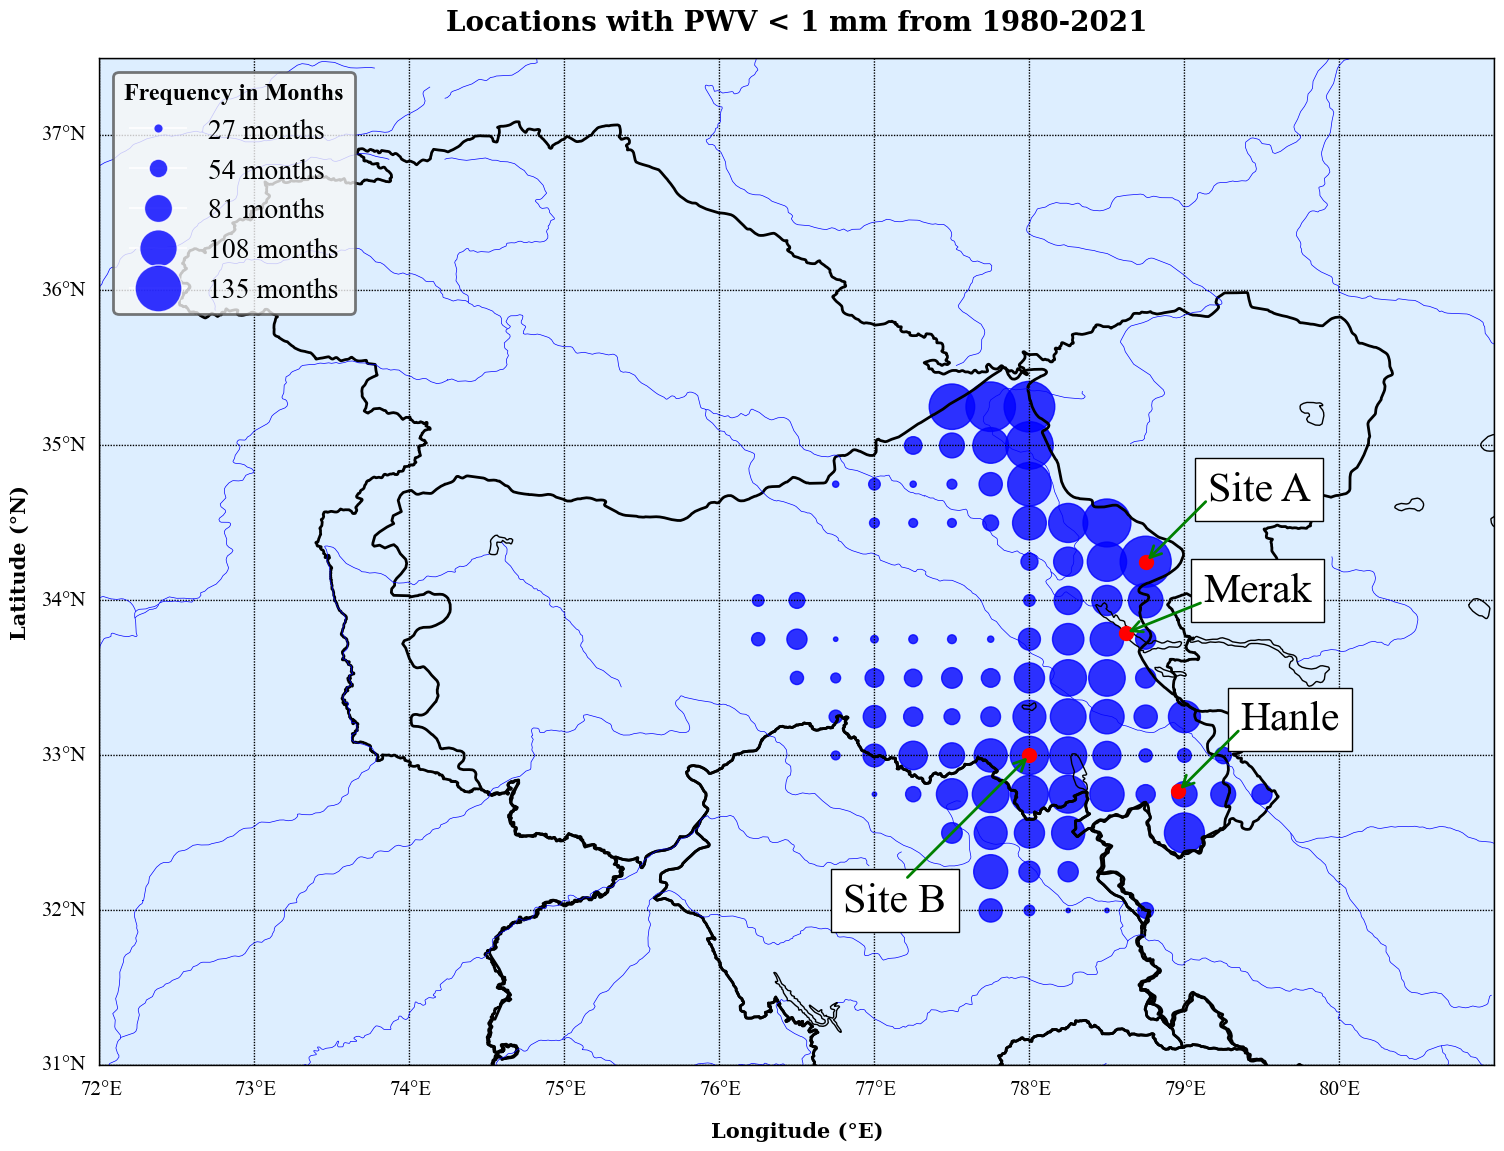

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shapefile as shp
import numpy as np

# Your existing code for setting up the figure and Basemap
plt.figure(figsize=(18, 18))


# Updated Basemap with new latitude and longitude boundaries
m = Basemap(
    llcrnrlat=31,    # lower-left corner latitude
    urcrnrlat=37.5,  # upper-right corner latitude
    llcrnrlon=72,    # lower-left corner longitude
    urcrnrlon=81,    # upper-right corner longitude
    resolution='h'
)

m.drawcoastlines()
# Updated parallels and meridians range
m.drawparallels(np.arange(31, 37.5, 1), labels=[True, False, False, False], fontsize=15)
m.drawmeridians(np.arange(72, 81, 1), labels=[0, 0, 0, 1], fontsize=15)
m.drawstates(linewidth=0.5, color='blue')


# First shapefile
sf1 = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\gadm41_IND_shp\gadm41_IND_1.shp")
for shape in sf1.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, color='black', linewidth=2)

# Second shapefile
sf2 = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\India_Shape_Full\India_Country_Boundary.shp")
for shape in sf2.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, color='black', linewidth=2)

#sf = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\gadm41_IND_shp\gadm41_IND_1.shp")
#sf = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\India_Shape_Full\india_st.shp")

# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     plt.plot(x, y, color='black', linewidth=2)
#     plt.xlim(xmin=73, xmax=81)
#     plt.ylim(ymin=31, ymax=36.5)

plt.xlim(xmin=72, xmax=81)
plt.ylim(ymin=31, ymax=37.5)

plt.grid()
plt.ylabel('Latitude (°N)', fontdict={'fontsize': 15, 'fontweight': 'bold', 'family': 'serif', 'color': '#000000', 'horizontalalignment': 'center'},labelpad=50)
plt.xlabel('Longitude (°E)', fontdict={'fontsize': 15, 'fontweight': 'bold', 'family': 'serif', 'color': '#000000', 'horizontalalignment': 'center'},labelpad=40)


m.drawmapboundary()
m.drawlsmask()
m.drawrivers(color='blue', linewidth=0.5)
m.drawmapboundary(fill_color="#DDEEFF")

# Your existing code for plotting points and text labels
plt.plot(78.96, 32.77, 'o', color='red', markersize=10, label='Hanle')
plt.text(78.96 + 0.4, 32.77 + 0.4, 'Hanle', fontsize=30, font='Times New Roman', bbox=dict(boxstyle='square', edgecolor='black', facecolor='white'))

plt.plot(78.00, 33, 'o', color='red', markersize=10, label='Site B')
plt.text(78 - 1.2, 33 - 1.0, 'Site B', fontsize=30, font='Times New Roman', bbox=dict(boxstyle='square', edgecolor='black', facecolor='white'))

plt.plot(78.75, 34.25, 'o', color='red', markersize=10, label='Site A')
plt.text(78.75 + 0.4, 34.25+ 0.4, 'Site A', fontsize=30, font='Times New Roman', bbox=dict(boxstyle='square', edgecolor='black', facecolor='white'))

plt.plot(78.62,33.79,  'o', color='red', markersize=10, label='Merak')
plt.text(78.62+0.5,33.8+0.2, 'Merak',fontsize=30, font='Times New Roman', bbox=dict(boxstyle='square', edgecolor='black', facecolor='white'))

# Add arrows with green lines and red arrowheads
plt.annotate('', xy=(78.96, 32.77), xytext=(78.96 + 0.4, 32.77 + 0.4),
             arrowprops=dict(arrowstyle='->', lw=2, color='green', mutation_scale=20))

plt.annotate('', xy=(78.00, 33), xytext=(78 - 0.8, 33 - 0.8),
             arrowprops=dict(arrowstyle='->', lw=2, color='green', mutation_scale=20))

plt.annotate('', xy=(78.75, 34.25), xytext=(78.75 + 0.4, 34.25 + 0.4),
             arrowprops=dict(arrowstyle='->', lw=2, color='green', mutation_scale=20))

plt.annotate('', xy=(78.62,33.79), xytext=(78.62+0.5,33.79+0.2),
                arrowprops=dict(arrowstyle='->', lw=2, color='green', mutation_scale=20))

# Set the title font size directly
plt.title('Locations with PWV < 1 mm from 1980-2021', fontdict={'fontsize': 20, 'fontweight': 'bold', 'family': 'serif', 'color': '#000000', 'horizontalalignment': 'center'}, pad=20)


scatter = plt.scatter(all_data_points[:, 1], all_data_points[:, 0], s=all_data_points[:, 2] * 10, color='blue', alpha=0.8, label='Frequency in months')

# Extract 5 evenly spaced points from all_data_points[:, 2], including the maximum and minimum values
legend_labels = np.linspace(np.min(all_data_points[:, 2]), np.max(all_data_points[:, 2]), 6, dtype=int)
legend_labels = np.delete(legend_labels, 0)

# Create a custom legend with two columns: bubble and number of months
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=size*0.25, alpha=0.8) for size in legend_labels]
# if label == 1: then label = '1 month' else label = 'n months'
legend_labels = [f'{label} month' if label == 1 else f'{label} months' for label in legend_labels]

# Add the legend with improved styling
legend = plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left', fontsize=20, title='Frequency in Months')
legend.set_title('Frequency in Months', prop={'size':'xx-large', 'weight':'bold'})

# Customize the legend border and background
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('#555555')
legend.get_frame().set_facecolor('#f7f7f7')

plt.savefig("all_points.png", dpi=500, bbox_inches='tight')
# Show the plot
plt.show()

NameError: name 'all_points_data' is not defined

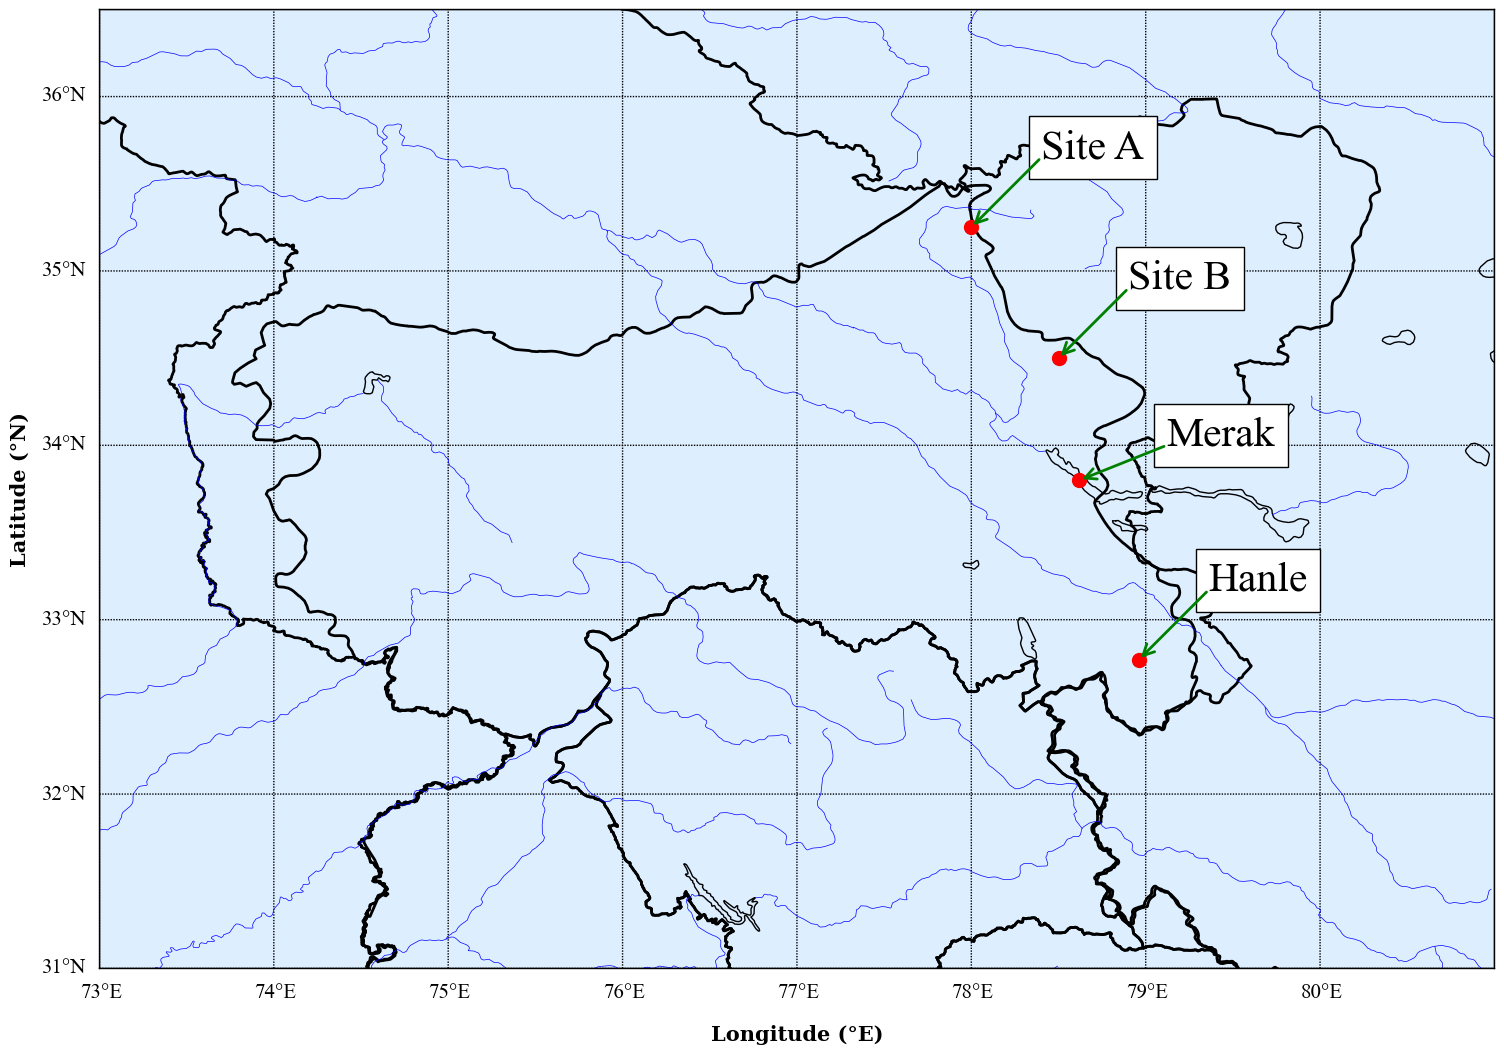

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shapefile as shp
import numpy as np
from scipy.stats import gaussian_kde

# # Sample data - replace this with your actual data
# all_points_data = np.random.rand(100, 3)
# all_points_data[:, 0] = 31 + (36.5 - 31) * all_points_data[:, 0]  # lat
# all_points_data[:, 1] = 73 + (81 - 73) * all_points_data[:, 1]  # lon
# all_points_data[:, 2] *= 12  # data points (number of months)

# Setting up the figure and Basemap
plt.figure(figsize=(18, 18))
m = Basemap(
    llcrnrlat=31,
    urcrnrlat=36.5,
    llcrnrlon=73,
    urcrnrlon=81,
    resolution='h'
)

m.drawcoastlines()
m.drawparallels(np.arange(31, 36.5, 1), labels=[True, False, False, False], fontsize=15)
m.drawmeridians(np.arange(73, 81, 1), labels=[0, 0, 0, 1], fontsize=15)
m.drawstates(linewidth=0.5, color='blue')

# First shapefile
sf1 = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\gadm41_IND_shp\gadm41_IND_1.shp")
for shape in sf1.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, color='black', linewidth=2)

# Second shapefile
sf2 = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\India_Shape_Full\India_Country_Boundary.shp")
for shape in sf2.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, color='black', linewidth=2)

#sf = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\gadm41_IND_shp\gadm41_IND_1.shp")
#sf = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\India_Shape_Full\india_st.shp")

# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     plt.plot(x, y, color='black', linewidth=2)
#     plt.xlim(xmin=73, xmax=81)
#     plt.ylim(ymin=31, ymax=36.5)

plt.xlim(xmin=73, xmax=81)
plt.ylim(ymin=31, ymax=36.5)
plt.grid()
plt.ylabel('Latitude (°N)', fontdict={'fontsize': 15, 'fontweight': 'bold', 'family': 'serif', 'color': '#000000', 'horizontalalignment': 'center'}, labelpad=50)
plt.xlabel('Longitude (°E)', fontdict={'fontsize': 15, 'fontweight': 'bold', 'family': 'serif', 'color': '#000000', 'horizontalalignment': 'center'}, labelpad=40)

m.drawmapboundary()
m.drawlsmask()
m.drawrivers(color='blue', linewidth=0.5)
m.drawmapboundary(fill_color="#DDEEFF")


# Your existing code for plotting points and text labels

# Your existing code for plotting points and text labels
plt.plot(78.96, 32.77, 'o', color='red', markersize=10, label='Hanle')
plt.text(78.96 + 0.4, 32.77 + 0.4, 'Hanle', fontsize=30, font='Times New Roman', bbox=dict(boxstyle='square', edgecolor='black', facecolor='white'))

plt.plot(78.00, 35.25, 'o', color='red', markersize=10, label='Site A')
plt.text(78 + 0.4, 35.25 + 0.4, 'Site A', fontsize=30, font='Times New Roman', bbox=dict(boxstyle='square', edgecolor='black', facecolor='white'))

plt.plot(78.50, 34.50, 'o', color='red', markersize=10, label='Site B')
plt.text(78.50 + 0.4, 34.50 + 0.4, 'Site B', fontsize=30, font='Times New Roman', bbox=dict(boxstyle='square', edgecolor='black', facecolor='white'))

plt.plot(78.62,33.8,  'o', color='red', markersize=10, label='Merak')
plt.text(78.62+0.5,33.8+0.2, 'Merak',fontsize=30, font='Times New Roman', bbox=dict(boxstyle='square', edgecolor='black', facecolor='white'))

# Add arrows with green lines and red arrowheads
plt.annotate('', xy=(78.96, 32.77), xytext=(78.96 + 0.4, 32.77 + 0.4),
             arrowprops=dict(arrowstyle='->', lw=2, color='green', mutation_scale=20))

plt.annotate('', xy=(78.00, 35.25), xytext=(78 + 0.4, 35.25 + 0.4),
             arrowprops=dict(arrowstyle='->', lw=2, color='green', mutation_scale=20))

plt.annotate('', xy=(78.50, 34.50), xytext=(78.50 + 0.4, 34.50 + 0.4),
             arrowprops=dict(arrowstyle='->', lw=2, color='green', mutation_scale=20))

plt.annotate('', xy=(78.62,33.8), xytext=(78.62+0.5,33.8+0.2),
                arrowprops=dict(arrowstyle='->', lw=2, color='green', mutation_scale=20))

# Set the title font size directly
# Prepare data for heatmap
lat, lon, data = all_points_data[:, 0], all_points_data[:, 1], all_points_data[:, 2]

# Create a grid
grid_x, grid_y = np.mgrid[31:36.5:100j, 73:81:100j]

# Kernel Density Estimation
kde = gaussian_kde(np.vstack([lat, lon]), weights=data)
kde_values = kde(np.vstack([grid_x.ravel(), grid_y.ravel()]))

# Reshape for the grid
kde_values = kde_values.reshape(grid_x.shape)

# Plotting the heatmap
m.imshow(kde_values, origin='lower', extent=[73, 81, 31, 36.5], cmap='hot', alpha=0.7)

# Set the title
plt.title('Locations with PWV < 1 mm from 1980-2021', fontdict={'fontsize': 20, 'fontweight': 'bold', 'family': 'serif', 'color': '#000000', 'horizontalalignment': 'center'}, pad=20)

#plt.savefig("all_points_heatmap.png", dpi=500)
plt.show()

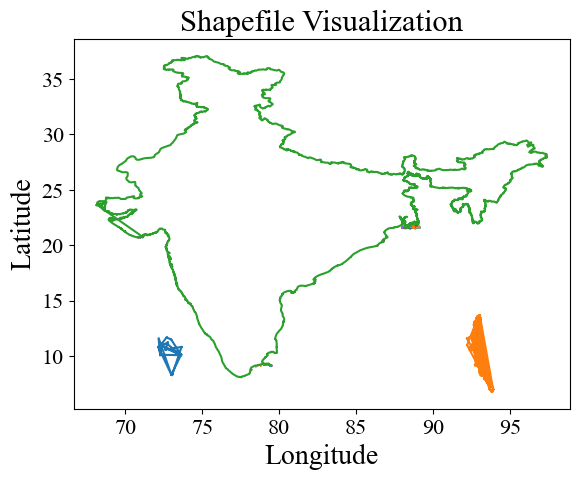

In [27]:
import shapefile  # Requires pyshp
import matplotlib.pyplot as plt

def plot_shapefile(shapefile_path):
    """
    Plots the geometries from a shapefile.
    
    :param shapefile_path: The path to the shapefile.
    """
    # Read the shapefile
    sf = shapefile.Reader(shapefile_path)
    
    # Set up the plot
    plt.figure()
    
    # Go through all shapes in the shapefile
    for shape in sf.shapes():
        # Extract the points of each shape
        points = shape.points
        x = [p[0] for p in points]
        y = [p[1] for p in points]
        
        # Plot the points
        plt.plot(x, y)

    # Set labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Shapefile Visualization')

    # Show the plot
    plt.show()

# Replace with the path to your shapefile
shapefile_path = "D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\India_Shape_Full\India_Country_Boundary.shp"
#hapefile_path = "D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\gadm41_IND_shp\gadm41_IND_1.shp"
plot_shapefile(shapefile_path)


In [24]:
import geopandas as gpd

# Define the original shapefile path
shapefile_path = "D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\India_Shape_Full\India_Country_Boundary.shp"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Check the current coordinate reference system (CRS)
print("Original CRS:", gdf.crs)

# Reproject to WGS84 (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Save the reprojected file back to the original location
gdf.to_file(shapefile_path)

# Now, you can use this shapefile in your Basemap plotting code



Original CRS: EPSG:3857
